# **Segmentação de clientes com K-means**

# **Planejamento**

### **Informações sobre o Conjunto de Dados**

Este projeto usa um conjunto de dados chamado [Online Retail.xlsx](https://archive.ics.uci.edu/dataset/352/online+retail), que contém `581.587` registros e `8` variáveis sobre um conjunto de dados transacionais que contém todas as transações ocorridas entre 01/12/2010 e 09/12/2011 para um varejo on-line não comercial registrado e sediado no Reino Unido.

| Nome da Variável | Papel   | Tipo         | Descrição                                                                 |
|------------------|---------|--------------|---------------------------------------------------------------------------|
| InvoiceNo        | ID      | Categórico   | Número de 6 dígitos atribuído exclusivamente a cada transação. Prefixo 'C' = cancelamento |
| StockCode        | ID      | Categórico   | Número de 5 dígitos atribuído exclusivamente a cada produto               |
| Description      | Recurso | Categórico   | Nome do produto                                                           |
| Quantity         | Recurso | Inteiro      | Quantidade de cada produto por transação                                 |
| InvoiceDate      | Recurso | Data         | Data e hora em que cada transação ocorreu                                |
| UnitPrice        | Recurso | Contínuo     | Preço unitário do produto                                                |
| CustomerID       | Recurso | Categórico   | Número de 5 dígitos atribuído exclusivamente a cada cliente              |
| Country          | Recurso | Categórico   | País de residência do cliente                                            |
                                                                        

### **Objetivo**

O objetivo principal é segmentar clientes em clusters com base em seus comportamentos de compra e propor ações de marketing direcionadas para cada segmento com base nos achados.

---

## **Etapa 1. Importação e Configuração**

* Importar pacotes
* Carregar conjunto de dados

### 1.1. Importar Pacotes

In [1]:
# ====================================================================================
# PACOTES OPERACIONAIS PADRÃO
# ====================================================================================
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# ====================================================================================
# PACOTES DE VISUALIZAÇÃO
# ====================================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ====================================================================================
#  PACOTES PARA MODELAGEM E AVALIAÇÃO
# ====================================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ====================================================================================


### 1.2. Carregar Dados

Leia o conjunto de dados chamado `online_retail.csv`.

In [2]:
# Carregar o conjunto de dados em um dataframe
df = pd.read_csv(
    "C:/Users/user/Documents/#1 Ofice Work/#3 Projeto/#3 Projetos até execução/Segmentação de Clientes com K-Means/Dataset para trabalhar/online_retail.csv",
    sep=';',
    encoding='latin1' # É uma boa prática manter o encoding
)

# Exibir as primeiras linhas do dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom


---

## **Etapa 2. Visão geral**

* Informações sobre os dados

### 2.1. Informações sobre os dados

In [3]:
# Tipos de dados e contagem de nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  object 
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# Estatísticas descritivas para colunas numéricas
df.describe()

,Quantity,CustomerID
count,541909.000000,406829.000000
mean,9.552250,15287.690570
std,218.081158,1713.600303
min,-80995.000000,12346.000000
25%,1.000000,13953.000000
50%,3.000000,15152.000000
75%,10.000000,16791.000000
max,80995.000000,18287.000000


In [5]:
# Estatísticas descritivas para colunas categóricas
df.describe(include=['object'])

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,Country
count,541909,541909,540455,541909,541909,541909
unique,25900,4070,4223,23260,1630,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31/10/2011 14:41,"1,25",United Kingdom
freq,1114,2313,2369,1114,50496,495478


<hr style="border: none; border-top: 1px dashed #ccc;">

**Observações Iniciais:**

*   **Dados Ausentes Críticos:** Cerca de 25% das transações (`135.080` registros) não possuem um `CustomerID` associado. Como o objetivo é a segmentação de clientes, esses registros são inutilizáveis para a análise RFM. A coluna `Description` também possui valores nulos, mas não é considerada essencial para o escopo deste projeto.

*   **Tipos de Dados Incorretos:**
    *   `InvoiceDate` foi carregado como texto (`object`) em vez de um formato de data (`datetime`).
    *   `UnitPrice` foi carregado como texto (`object`). Isso ocorre porque os preços utilizam a vírgula (`,`) como separador decimal, um padrão de formatação regional que, embora comum, precisa ser convertido para o formato numérico padrão (ponto decimal) para possibilitar cálculos matemáticos.

*   **Valores de Transação Inválidos:**
    *   A coluna `Quantity` contém valores negativos, que, conforme o dicionário de dados, representam transações de cancelamento e devem ser excluídas da análise de compras.
    *   Foram observadas transações com `UnitPrice` igual a zero, que não representam uma venda real e precisam ser tratadas.

---

## **Etapa 3. Limpeza de dados**

* Valores ausentes
* Erro ortográficos e tabulações
* Distribuições e Outliers
* Tratamento de Duplicatas
* Erros de formatação

### 3.1. Valores Ausentes

Investigar os valores ausentes nos dados.

In [6]:
# Avaliação do impacto dos dados ausentes
percentual_ausente = (df.isna().sum() / len(df)) * 100

percentual_ausente

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [7]:
# Seleciona as linhas que têm pelo menos um valor nulo
rows_with_missing_values = df[df.isnull().any(axis=1)]

# Exibe as linhas com valores ausentes
rows_with_missing_values

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01/12/2010 11:52,0,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01/12/2010 14:32,"2,51",NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01/12/2010 14:32,"2,51",NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01/12/2010 14:32,"0,85",NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01/12/2010 14:32,"1,66",NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,09/12/2011 10:26,"4,13",NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,09/12/2011 10:26,"4,13",NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,09/12/2011 10:26,"4,96",NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,09/12/2011 10:26,"10,79",NaN,United Kingdom


In [8]:
# Remove linhas que contêm valores ausentes
df = df.dropna().reset_index(drop=True)

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A análise inicial revelou valores ausentes em duas colunas: `CustomerID` (24,9%) e `Description` (0,27%). Como o foco é segmentar clientes pelo comportamento de compra (Análise RFM), o `CustomerID` é fundamental — sem ele, não consigo calcular Recência, Frequência e Valor Monetário, tornando essas transações inúteis. Por isso, optei por remover todas as linhas com valores faltantes usando `.dropna()`. Após essa limpeza, o índice do DataFrame foi reiniciado para manter a numeração sequencial.

### 3.2. Erros de Digitação e Tabulação

Investigar possiveis erros inseridos no dataset.

#### **Coluna: `[Country]`**

In [9]:
# 1. Ver valores únicos de uma coluna específica
df['Country'].unique()

# 2. Ver valores únicos com suas contagens
df['Country'].value_counts()


Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


<hr style="border: none; border-top: 1px dashed #ccc;">

**Alterações:**

In [10]:
# Criar um dicionário de alterações
alterar = {
    'EIRE': 'Ireland',
    'RSA': 'South Africa',
    'USA': 'United States'
}

# Aplicar as correções na coluna 'Country'
df['Country'] = df['Country'].replace(alterar)

In [11]:
# Listar de termos a serem removidos
remover = ['Unspecified', 'European Community']

# Remover as linhas
df = df[~df['Country'].isin(remover)]

In [12]:
# 1. Ver valores únicos de uma coluna específica
df['Country'].unique()

# 2. Ver valores únicos com suas contagens
df['Country'].value_counts()


Country
United Kingdom          361878
Germany                   9495
France                    8491
Ireland                   7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
United States              291
Israel                     250
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
South Africa                58
Lebanon                     45
Lithuania                   35
Brazil                      32


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A coluna `Country` não apresenta erros ortográficos. No entanto, observei algumas inconsistências e casos especiais que precisaram ser alterados para a padronização da analise:

- **EIRE**: Este é o nome em irlandês para Irlanda. Embora seja correto e possivelmente intencional no contexto de uma empresa sediada no Reino Unido, difere do padrão de nomes em inglês usado para outros países, como "Spain" ou "France". Para consistência, optei por padronizar para "Ireland".

- **USA e RSA**: Estes são abreviações para "United States of America" (Estados Unidos da América) e "Republic of South Africa" (República da África do Sul), respectivamente. Embora sejam reconhecidos, a maioria das outros países na lista é apresentada por seus nomes completos, logo optei por "United States" e "South Africa".

- **Unspecified**: Não é um país, mas sim um marcador para dados não especificados. Isso não é um erro ortográfico, mas a abordagem mais limpa é remover essas linhas, já que elas não agregam informação geográfica útil para a segmentação.

- **Channel Islands e European Community**: Esses não são países soberanos, mas sim uma região (Ilhas do Canal) e um grupo (União Europeia). No contexto de um varejo do Reino Unido, essas designações podem ser válidas para indicar a localização dos clientes, mas não seguem o padrão como os demais na lista.
   * Devido à sua ambiguidade e baixa contagem (61 linhas), removi European Community.
   * Channel Islands como dependência da Coroa Britânica, mantê-la como uma categoria separada faz sentido neste contexto. 

#### **Coluna: `[Quantity]`**

In [13]:
# 1. Ver valores únicos de uma coluna específica 
df['Quantity'].unique()

# 2. Ver valores únicos com suas contagens
df['Quantity'].value_counts().sort_index()

Quantity
-80995    1
-74215    1
-9360     1
-3114     1
-2000     1
         ..
 4300     1
 4800     1
 12540    1
 74215    1
 80995    1
Name: count, Length: 436, dtype: int64

In [14]:
# 1. Criar uma condição booleana para encontrar linhas onde 'Quantity' é menor que 0
condicao_negativa = df['Quantity'] < 0

# 2. Usar essa condição para filtrar o DataFrame
linhas_negativas = df[condicao_negativa].sort_values(by=['Quantity'])

# 3. Exibir o resultado
print(f"Encontradas {len(linhas_negativas)} linhas com quantidade negativa.")
print()
display(linhas_negativas)

Encontradas 8904 linhas com quantidade negativa.



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
406350,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,09/12/2011 09:27,"2,08",16446.0,United Kingdom
38125,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,18/01/2011 10:17,"1,04",12346.0,United Kingdom
3102,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,02/12/2010 14:23,"0,03",15838.0,United Kingdom
112372,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,18/04/2011 13:08,"2,1",15749.0,United Kingdom
112371,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,18/04/2011 13:08,"1,85",15749.0,United Kingdom
...,...,...,...,...,...,...,...,...
255925,C567536,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,21/09/2011 09:52,"7,95",14284.0,United Kingdom
255932,C567540,23173,REGENCY TEAPOT ROSES,-1,21/09/2011 10:00,"9,95",12384.0,Switzerland
123966,C552029,20982,12 PENCILS TALL TUBE SKULLS,-1,05/05/2011 18:11,"0,85",15622.0,United Kingdom
123962,C552029,22681,FRENCH BLUE METAL DOOR SIGN 6,-1,05/05/2011 18:11,"1,25",15622.0,United Kingdom


De acordo com as informações das colunas, na coluna `InvoiceNo` o prefixo 'C' indica cancelamento. Vou verificar se todas as faturas com quantidade negativa começam com 'C'.

In [15]:
# Repetindo a condição para filtrar o DataFrame
linhas_negativas = df[condicao_negativa].sort_values(by=['Quantity'])

# Contando quantas faturas começam com 'C'
sao_cancelamentos = linhas_negativas['InvoiceNo'].str.startswith('C').sum()

print(f"Encontradas {len(linhas_negativas)} linhas com quantidade negativa.")
print(f"Encontradas {sao_cancelamentos} faturas que começam com 'C'.")

Encontradas 8904 linhas com quantidade negativa.
Encontradas 8904 faturas que começam com 'C'.


In [16]:
# Filtra o DataFrame para manter apenas as linhas onde a quantidade é positiva
df = df[df['Quantity'] > 0]

In [17]:
# 3. Exibir o resultado
print(f"Encontradas {len(linhas_negativas)} linhas com quantidade negativa.")
print()
display(linhas_negativas)

Encontradas 8904 linhas com quantidade negativa.



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
406350,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,09/12/2011 09:27,"2,08",16446.0,United Kingdom
38125,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,18/01/2011 10:17,"1,04",12346.0,United Kingdom
3102,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,02/12/2010 14:23,"0,03",15838.0,United Kingdom
112372,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,18/04/2011 13:08,"2,1",15749.0,United Kingdom
112371,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,18/04/2011 13:08,"1,85",15749.0,United Kingdom
...,...,...,...,...,...,...,...,...
255925,C567536,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,21/09/2011 09:52,"7,95",14284.0,United Kingdom
255932,C567540,23173,REGENCY TEAPOT ROSES,-1,21/09/2011 10:00,"9,95",12384.0,Switzerland
123966,C552029,20982,12 PENCILS TALL TUBE SKULLS,-1,05/05/2011 18:11,"0,85",15622.0,United Kingdom
123962,C552029,22681,FRENCH BLUE METAL DOOR SIGN 6,-1,05/05/2011 18:11,"1,25",15622.0,United Kingdom


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A análise da coluna `Quantity` revelou a existência de **8.904 transações com valores negativos**. Uma investigação foi conduzida para validar a hipótese de que essas entradas correspondem a cancelamentos de pedidos, indicados pelo prefixo 'C' na coluna `InvoiceNo`, conforme descrito no dicionário de dados. 

A verificação confirmou que **100% das transações com quantidade negativa possuem um `InvoiceNo` iniciado por 'C'**. Isso comprova que os registros representam devoluções ou cancelamentos, e não compras. Uma vez que a análise se concentra no comportamento de compra dos clientes, a presença desses dados distorceria as métricas de Frequência e Valor Monetário. Portanto, todas as 8.904 linhas correspondentes a cancelamentos foram removidas do conjunto de dados para garantir a precisão da análise subsequente.

Optei por retirar as linhas devido ao projeto ter um objetivo claro. As transações negativas (cancelamentos) são "ruído", elas não serão usadas em nenhuma etapa futura. Mantê-las em um subconjunto separado só consumiria memória e criaria uma variável que não seria utilizada.

#### **Verificar e corrigir espaços extras**

In [18]:
# 1. Identificar quais colunas são de texto (tipo 'object')
colunas_de_texto = df.select_dtypes(include=['object']).columns

print("Verificando e corrigindo espaços nas seguintes colunas de texto:")
print(colunas_de_texto)

# 2. Iterar sobre cada coluna de texto e aplicar a limpeza
for col in colunas_de_texto:
    # Remove espaços no início e no fim de cada string
    df[col] = df[col].str.strip()
    
    # Substitui múltiplos espaços no meio por um único espaço
    df[col] = df[col].str.replace(r'\s+', ' ', regex=True)

print("\nLimpeza de espaços nos dados concluída!")

Verificando e corrigindo espaços nas seguintes colunas de texto:
Index(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'UnitPrice',
       'Country'],
      dtype='object')

Limpeza de espaços nos dados concluída!


### 3.3. Tratamento de Duplicatas

Identificar e remover registros que são cópias exatas de outros.

In [19]:
# Total de duplicatas
df.duplicated().sum()

5189

In [20]:
# Encontra as duplicatas e as ordena por 'InvoiceNo', 'StockCode' e 'InvoiceDate' de uma só vez
duplicates_sorted = df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode', 'InvoiceDate'])

# Exibe as duplicatas agrupadas e ordenadas
print("Duplicatas encontradas:")
display(duplicates_sorted)

Duplicatas encontradas:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,01/12/2010 11:45,"1,25",17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,01/12/2010 11:45,"1,25",17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,01/12/2010 11:45,"4,95",17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,01/12/2010 11:45,"4,95",17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,01/12/2010 11:45,"2,1",17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
406575,581538,23275,SET OF 3 HANGING OWLS OLLIE BEAK,1,09/12/2011 11:34,"1,25",14446.0,United Kingdom
406576,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,09/12/2011 11:34,"2,49",14446.0,United Kingdom
406609,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,09/12/2011 11:34,"2,49",14446.0,United Kingdom
406586,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,09/12/2011 11:34,"2,08",14446.0,United Kingdom


In [21]:
# Eliminar linhas duplicadas após sua primeira ocorrência
df = df.drop_duplicates(keep='first')

In [22]:
# Total de duplicatas
df.duplicated().sum()

0

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Foi identificada a presença de **5.222 registros duplicados** no conjunto de dados. Para garantir a integridade dos dados essas linhas duplicadas foram removidas, mantendo-se apenas a primeira ocorrência de cada registro.

### 3.4. Erros de Formatação e Transformação

Esta seção lida com problemas estruturais do dataset.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392431 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392431 non-null  object 
 1   StockCode    392431 non-null  object 
 2   Description  392431 non-null  object 
 3   Quantity     392431 non-null  int64  
 4   InvoiceDate  392431 non-null  object 
 5   UnitPrice    392431 non-null  object 
 6   CustomerID   392431 non-null  float64
 7   Country      392431 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 26.9+ MB


In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,"3,39",17850.0,United Kingdom


#### **Coluna: `[InvoiceDate]`**

In [25]:
# Resolvendo problema de formato gerado pelo Excel
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

# Verificar
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 392431 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392431 non-null  object        
 1   StockCode    392431 non-null  object        
 2   Description  392431 non-null  object        
 3   Quantity     392431 non-null  int64         
 4   InvoiceDate  392431 non-null  datetime64[ns]
 5   UnitPrice    392431 non-null  object        
 6   CustomerID   392431 non-null  float64       
 7   Country      392431 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 26.9+ MB
None


#### **Coluna: `[CustomerID]` e `[UnitPrice]`**

In [26]:
# Substituir a vírgula pelo ponto na coluna 'UnitPrice'
df['UnitPrice'] = df['UnitPrice'].str.replace(',', '.')

In [27]:
# Converter as duas colunas
df = df.astype({
    'CustomerID': 'int64',
    'UnitPrice': 'float64'
})

In [28]:
# Resolvendo problema de formato gerado pelo Excel
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

# Verificar
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 392431 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392431 non-null  object        
 1   StockCode    392431 non-null  object        
 2   Description  392431 non-null  object        
 3   Quantity     392431 non-null  int64         
 4   InvoiceDate  392431 non-null  datetime64[ns]
 5   UnitPrice    392431 non-null  float64       
 6   CustomerID   392431 non-null  int64         
 7   Country      392431 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 26.9+ MB
None


In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

*   **`InvoiceDate`**: A coluna, originalmente do tipo `object` (texto), foi transformada para o tipo `datetime64[ns]`. Foi utilizado o parâmetro `dayfirst=True` para assegurar a correta interpretação do formato de data `DD/MM/YYYY` presente no conjunto de dados.

*   **`UnitPrice`**: Esta coluna estava como `object` (texto) e utilizava a vírgula como separador decimal. O processo de correção envolveu duas etapas:
    1.  Substituição de todas as vírgulas por pontos (`.`).
    2.  Conversão da coluna para o tipo numérico `float64`.

<blank>

*   **`CustomerID`**: A coluna de identificação do cliente estava como `float64`, um efeito colateral de possuir valores nulos. Agora limpa, foi convertida para `int64`, que é o tipo de dado semanticamente correto e mais eficiente para um identificador numérico inteiro.

### 3.5. Distribuições e Outliers

Identificar valores extremos em colunas numéricas que podem distorcer a análise.

In [30]:
df.describe(include=[np.number])

,Quantity,UnitPrice,CustomerID
count,392431.000000,392431.000000,392431.000000
mean,13.157987,3.125277,15288.716679
std,181.657830,22.249022,1713.377682
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13956.000000
50%,6.000000,1.950000,15152.000000
75%,12.000000,3.750000,16792.000000
max,80995.000000,8142.750000,18287.000000


#### **Coluna: `[Quantity]`**

In [31]:
percentile25 = df['Quantity'].quantile(0.25)
percentile75 = df['Quantity'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(f"Estatísticas para detecção de outliers na coluna 'Quantity':")
print()
print(f"Percentil 25%: {percentile25:.2f}")
print(f"Percentil 75%: {percentile75:.2f}")
print(f"IQR (Intervalo Interquartil): {iqr:.2f}")
print()
print(f"Limite inferior: {lower_limit:.2f}")
print(f"Limite superior: {upper_limit:.2f}")
print(f"Valores abaixo do limite inferior: {sum(df['Quantity'] < lower_limit)}")
print(f"Valores acima do limite superior: {sum(df['Quantity'] > upper_limit)}")
print()
print(f"Percentual de outliers: {((sum(df['Quantity'] < lower_limit) + sum(df['Quantity'] > upper_limit)) / len(df) * 100):.2f}%")
print("\n" + "="*50 + "\n")

Estatísticas para detecção de outliers na coluna 'Quantity':

Percentil 25%: 2.00
Percentil 75%: 12.00
IQR (Intervalo Interquartil): 10.00

Limite inferior: -13.00
Limite superior: 27.00
Valores abaixo do limite inferior: 0
Valores acima do limite superior: 25623

Percentual de outliers: 6.53%




In [32]:
# Encontrar os limites para o 0.5% inferior e 99.5% superior
limite_inferior_extremo = df['Quantity'].quantile(0.005)
limite_superior_extremo = df['Quantity'].quantile(0.995)

print(f"Limite inferior (quantil 0.5%): {limite_inferior_extremo}")
print(f"Limite superior (quantil 99.5%): {limite_superior_extremo}")
print("\n" + "="*50 + "\n")

Limite inferior (quantil 0.5%): 1.0
Limite superior (quantil 99.5%): 200.0




In [33]:
# Filtrar o DataFrame para análise
outliers_extremos = df[(df['Quantity'] < limite_inferior_extremo) | (df['Quantity'] > limite_superior_extremo)]
print(f"\nNúmero de outliers usando quantis extremos: {len(outliers_extremos)}")
print(f"Percentual de outliers: {len(outliers_extremos) / len(df) * 100:.2f}%")
print()
outliers_extremos


Número de outliers usando quantis extremos: 1714
Percentual de outliers: 0.44%



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029,United Kingdom
219,536390,20668,DISCO BALL CHRISTMAS DECORATION,288,2010-12-01 10:19:00,0.10,17511,United Kingdom
729,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694,United Kingdom
869,536477,21137,BLACK RECORD COVER FRAME,480,2010-12-01 12:27:00,3.39,16210,United Kingdom
...,...,...,...,...,...,...,...,...
405990,581457,82484,WOOD BLACK BOARD ANT WHITE FINISH,204,2011-12-08 18:43:00,4.80,18102,United Kingdom
405998,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949,United Kingdom
405999,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949,United Kingdom
406270,581476,16008,SMALL FOLDING SCISSOR(POINTED EDGE),240,2011-12-09 08:48:00,0.12,12433,Norway


Esses valores discrepantes podem representar atacadistas. Vou aprofundar a investigação tentanto identificar clientes únicos responsáveis por essas 1714 transações de alto volume.

In [34]:
# Quantos clientes únicos estão nesse grupo de "outliers"?
num_clientes_atacado = outliers_extremos['CustomerID'].nunique()

num_clientes_atacado

258

In [35]:
# Qual o valor total gerado por essas transações "discrepantes"?
outliers_extremos['TotalPrice'] = outliers_extremos['Quantity'] * outliers_extremos['UnitPrice']
valor_total_outliers = outliers_extremos['TotalPrice'].sum()

valor_total_outliers

1193751.16

In [36]:
valor_total_geral = (df['Quantity'] * df['UnitPrice']).sum()

(valor_total_outliers / valor_total_geral) * 100

13.438228640382075

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A análise da distribuição da coluna `Quantity` revelou a presença de valores estatisticamente extremos (outliers). Uma investigação foi conduzida para determinar a natureza desses valores.

*   A aplicação do método do Intervalo Interquartil (IQR) sinalizou 6.53% das transações como outliers.
*   Uma análise mais focada nos valores mais extremos (o 0.5% superior do `Quantity`) identificou 1.714 transações de altíssimo volume.
*   A investigação desses registros revelou que eles não são erros, mas representam um comportamento de compra legítimo. As principais descobertas foram:
    *   As 1.714 transações de alto volume foram realizadas por um pequeno grupo de **258 clientes únicos**.
    *   Embora representem apenas **0.44%** do total de transações, elas são responsáveis por **13.44% do faturamento total**.

Estas descobertas confirmam a informação do dicionário de dados de que a empresa atende a clientes atacadistas (`wholesalers`). Os valores extremos na coluna `Quantity` representam este segmento de clientes. Remover esses dados seria um erro, pois eliminaria um grupo fundamental para o negócio e distorceria a segmentação de clientes. Portanto, a decisão tomada foi **manter todos os dados de `Quantity` no conjunto de dados**. A influência desses valores extremos será tratada na etapa de pré-processamento para o modelo de machine learning garantindo que o algoritmo de clustering possa analisar todos os segmentos de clientes de forma equilibrada.

#### **Coluna: `[UnitPrice]`**

In [37]:
# Limites pelo IQR
percentile25 = df['UnitPrice'].quantile(0.25)
percentile75 = df['UnitPrice'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(f"Estatísticas para detecção de outliers na coluna 'UnitPrice':")
print()
print(f"Percentil 25%: {percentile25:.2f}")
print(f"Percentil 75%: {percentile75:.2f}")
print(f"IQR (Intervalo Interquartil): {iqr:.2f}")
print()
print(f"Limite inferior: {lower_limit:.2f}")
print(f"Limite superior: {upper_limit:.2f}")
print(f"Valores abaixo do limite inferior: {sum(df['UnitPrice'] < lower_limit)}")
print(f"Valores acima do limite superior: {sum(df['UnitPrice'] > upper_limit)}")
print()
print(f"Percentual de outliers: {((sum(df['UnitPrice'] < lower_limit) + sum(df['UnitPrice'] > upper_limit)) / len(df) * 100):.2f}%")
print("\n" + "="*50 + "\n")

Estatísticas para detecção de outliers na coluna 'UnitPrice':

Percentil 25%: 1.25
Percentil 75%: 3.75
IQR (Intervalo Interquartil): 2.50

Limite inferior: -2.50
Limite superior: 7.50
Valores abaixo do limite inferior: 0
Valores acima do limite superior: 34070

Percentual de outliers: 8.68%




In [38]:
# Limites por percentis extremos
limite_inferior_extremo = df['UnitPrice'].quantile(0.005)
limite_superior_extremo = df['UnitPrice'].quantile(0.995)

print(f"Limite inferior (quantil 0.5%): {limite_inferior_extremo}")
print(f"Limite superior (quantil 99.5%): {limite_superior_extremo}")

# Filtrar o DataFrame para análise
outliers_extremos = df[(df['UnitPrice'] < limite_inferior_extremo) | (df['UnitPrice'] > limite_superior_extremo)]
print(f"\nNúmero de outliers usando quantis extremos: {len(outliers_extremos)}")

# tudo abaixo do limite inferior
abaixo_limite_inferior = df[df['UnitPrice'] < limite_inferior_extremo]
# tudo acima do limite superior
acima_limite_superior = df[df['UnitPrice'] > limite_superior_extremo]

# exibir resultados
print(f"Número de registros abaixo do limite inferior ({limite_inferior_extremo}):",
      len(abaixo_limite_inferior))
print(f"Número de registros acima do limite superior ({limite_superior_extremo}):",
      len(acima_limite_superior))

print()

print(f"Percentual de outliers: {len(outliers_extremos) / len(df) * 100:.2f}%")

print("\n" + "="*50 + "\n")

Limite inferior (quantil 0.5%): 0.19
Limite superior (quantil 99.5%): 16.95

Número de outliers usando quantis extremos: 3077
Número de registros abaixo do limite inferior (0.19): 1129
Número de registros acima do limite superior (16.95): 1948

Percentual de outliers: 0.78%




In [39]:
# ver as primeiras linhas de cada
display(abaixo_limite_inferior.sort_values(by='UnitPrice'))
print()
display(acima_limite_superior.sort_values(by='UnitPrice', ascending=False))


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
99945,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.00,14410,United Kingdom
336738,574920,22899,CHILDREN'S APRON DOLLY GIRL,1,2011-11-07 16:34:00,0.00,13985,United Kingdom
336106,574879,22625,RED KITCHEN SCALES,2,2011-11-07 13:22:00,0.00,13014,United Kingdom
265590,568384,M,Manual,1,2011-09-27 09:46:00,0.00,12748,United Kingdom
229359,564651,23270,SET OF 2 CERAMIC PAINTED HEARTS,96,2011-08-26 14:19:00,0.00,14646,Netherlands
...,...,...,...,...,...,...,...,...
54137,543447,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,24,2011-02-08 12:01:00,0.18,16265,United Kingdom
54766,543535,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,1,2011-02-09 13:37:00,0.18,17537,United Kingdom
281843,569864,21829,DINOSAUR KEYRINGS ASSORTED,216,2011-10-06 14:45:00,0.18,14533,United Kingdom
114282,550639,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,24,2011-04-19 15:46:00,0.18,14152,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
121396,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
316257,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
316282,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
302433,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
275959,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502,United Kingdom
...,...,...,...,...,...,...,...,...
198378,561102,POST,POSTAGE,1,2011-07-25 11:17:00,18.00,12412,Denmark
200361,561468,POST,POSTAGE,5,2011-07-27 13:00:00,18.00,12709,Germany
200372,561470,POST,POSTAGE,1,2011-07-27 13:14:00,18.00,12523,France
406688,581578,POST,POSTAGE,3,2011-12-09 12:16:00,18.00,12713,Germany


<hr style="border: none; border-top: 1px dashed #ccc;">

In [40]:
# Filtra StockCode que NÃO contenham dígitos (0–9) e retorna os únicos
contagem_sem_numeros = df.loc[
    ~df['StockCode'].str.contains(r'\d', regex=True, na=False),
    'StockCode'
].value_counts()

print(contagem_sem_numeros)

StockCode
POST            1096
M                285
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64


<hr style="border: none; border-top: 1px dashed #ccc;">

In [41]:
# Investigando UnitPrice = 0 
zero_price_rows = df[df['UnitPrice'] == 0]
print("Itens com Preço Zero")
print()
print(f"Número de linhas: {len(zero_price_rows)}")
print(f"Percentual de linhas: {(len(zero_price_rows) / len(df) * 100):.2f}%")
print("\n" + "="*50 + "\n")

Itens com Preço Zero

Número de linhas: 40
Percentual de linhas: 0.01%




In [42]:
# Verificando as descrições dos itens
zero_price_rows.value_counts(subset=['Description', 'Quantity'])

Description                          Quantity
Manual                               1           6
36 FOIL STAR CAKE CASES              144         1
OVAL WALL MIRROR DIAMANTE            1           1
PAPER BUNTING RETROSPOT              24          1
PAPER BUNTING VINTAGE PAISLEY        24          1
PARTY BUNTING                        4           1
PASTEL COLOUR HONEYCOMB FAN          5           1
PLASTERS IN TIN SKULLS               24          1
POLKADOT RAIN HAT                    144         1
RED KITCHEN SCALES                   2           1
REGENCY CAKESTAND 3 TIER             10          1
ROUND CAKE TIN VINTAGE GREEN         1           1
SET OF 2 CERAMIC CHRISTMAS REINDEER  192         1
SET OF 2 CERAMIC PAINTED HEARTS      96          1
SET OF 2 TRAYS HOME SWEET HOME       2           1
SET OF 6 NATIVITY MAGNETS            240         1
SET OF 6 SOLDIER SKITTLES            80          1
PADS TO MATCH ALL CUSHIONS           1           1
ORGANISER WOOD ANTIQUE WHITE        

<hr style="border: none; border-top: 1px dashed #ccc;">

**Alterações:**

In [43]:
# Remove as 40 linhas onde o preço unitário é exatamente 0.
df = df[df['UnitPrice'] > 0]

In [44]:
# 1. Identificar os StockCodes que não são produtos
contagem_sem_numeros = df.loc[
    ~df['StockCode'].str.contains(r'\d', regex=True, na=False),
    'StockCode'
].value_counts()

# 2. Remover essas linhas do DataFrame principal
df = df[~df['StockCode'].isin(contagem_sem_numeros)]

# Opcional: Verificar se foram removidos
print(f"\nVerificando se ainda existem: {df['StockCode'].isin(contagem_sem_numeros).sum()} ocorrências restantes.")


Verificando se ainda existem: 0 ocorrências restantes.


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A coluna `UnitPrice` possui três diferentes tipos de valores discrepantes que foram tratados de formas distintas.

1.  **Transações com Preço Zero (`UnitPrice` = 0):**
    * Foram encontradas 40 transações com preço unitário igual a zero.
    * Estes registros não representam uma venda genuína e foram considerados ruído. Todas as 40 linhas foram **removidas**.

<Blank>

2.  **Taxas de Serviço e Ajustes Manuais:**
    * Itens com `UnitPrice` muito elevado foram investigados. Observei que seus `StockCode`s correspondiam a taxas de serviço, e não a produtos (ex: 'POST', 'M'). Foi utilizada uma expressão regular para identificar todos os `StockCode`s que não continham dígitos, confirmando que se tratavam de entradas de não-produto.
    * Como essas taxas não refletem o comportamento de compra de produtos de um cliente e distorceriam a análise, todas as linhas associadas a esses códigos de serviço foram **removidas**.

<Blank>

3.  **Itens de Baixo Custo:**
    * Itens com preço unitário muito baixo, mas acima de zero, foram analisados.
    * Concluir que estes são produtos legítimos de baixo custo, que fazem parte do catálogo da loja. Portanto, estas transações foram **mantidas** no conjunto de dados.

---

# **Análise**

## **Etapa 4. Exploração de Dados e Análise**

### **4.1. Feature Engineering**

Nesta seção novas variáveis (features) serão criadas a partir das existentes para ajudar o objetivo da análise.

<hr style="border: none; border-top: 1px dashed #ccc;">

#### **[TotalPrice]**

**Objetivo:** Uma nova coluna com o objetivo de calcular o valor da compra total para cada transação de clientes.

In [45]:
# Implementação: Calcular faturamento total
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Verificação:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


<hr style="border: none; border-top: 1px dashed #ccc;">

#### **[snapshot_date]**

**Objetivo:** Esta variável pega a data da última transação no dataset e adiciona um dia para todas as "distâncias" de tempo sejam calculadas a partir deste ponto.

In [46]:
# Implementação: Data de referência
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Verificação:
snapshot_date

Timestamp('2011-12-10 12:50:00')

<hr style="border: none; border-top: 1px dashed #ccc;">

#### **[rfm_df]** 

**Objetivo:** Criar o novo dataframe agrupado por clinetes (CustomerID):

*	Recency (R):     A diferença entre a snapshot_date e a data da última compra do cliente em dias.
*	Frequency (F):   O número de faturas únicas (InvoiceNo.nunique()).
*	Monetary (M):    A soma do valor total de todas as compras (TotalPrice.sum()).


In [47]:
# Implementação: Agrupar por CustomerID e agregar para calcular R, F e M
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,  # Recência (R)
    'InvoiceNo': 'nunique',                                         # Frequência (F)
    'TotalPrice': 'sum'                                             # Valor Monetário (M)
})

# Renomear as colunas para maior clareza
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'MonetaryValue'}, inplace=True)

# Verificação:
rfm_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


### **4.2. Distribuição das variáveis**

#### Justificativa para a Separação:

Existe um grupo de clientes atacadistas que compram em grandes quantidades, representando uma siginficativa porcentagem do faturamento.

- Havia valores extremos em `Quantity`, correspondentes a transações desses atacadistas.
- A empresa atende tanto clientes de varejo quanto atacadistas, e ambos os segmentos são relevantes para o negócio.

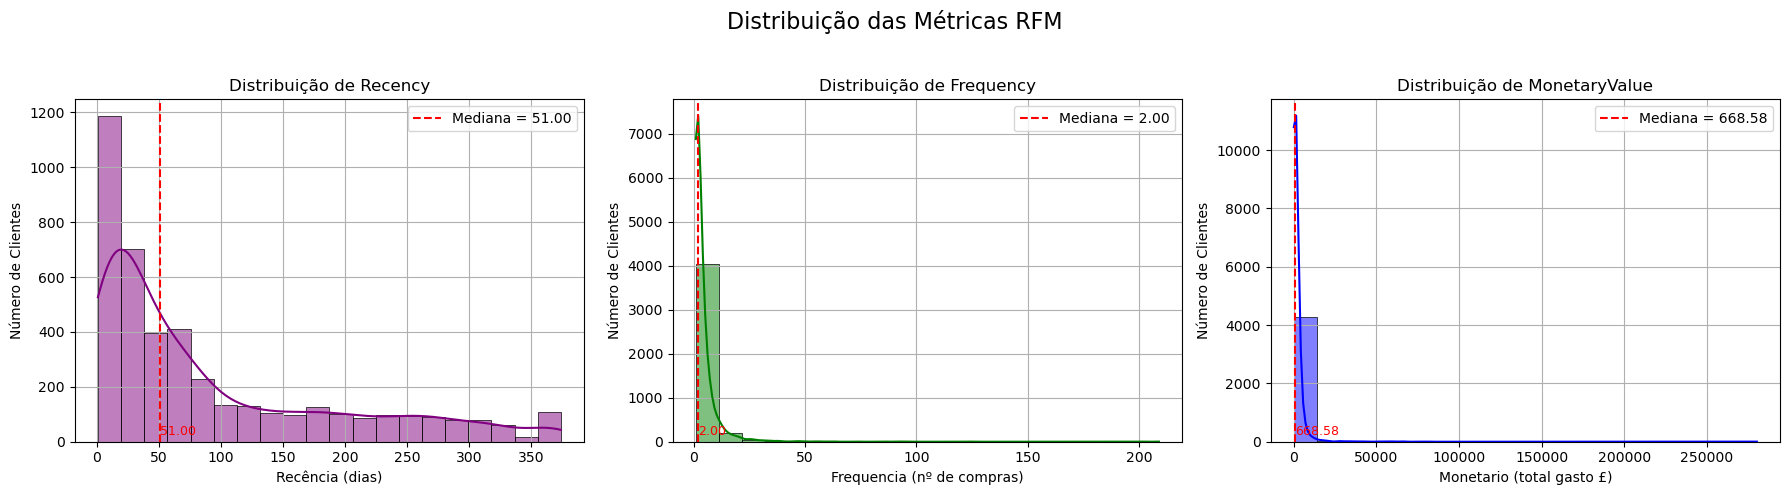

In [48]:
# 3 subgráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Distribuição das Métricas RFM", fontsize=16)

# Lista das colunas e títulos
colunas = ['Recency', 'Frequency', 'MonetaryValue']
titulos = ['Recência (dias)', 'Frequencia (nº de compras)', 'Monetario (total gasto £)']
cores = ['purple', 'green', 'blue']

# Loop para criar cada histograma
for i, col in enumerate(colunas):
    ax = axes[i]
    sns.histplot(rfm_df[col], bins=20, color=cores[i], kde=True, linewidth=0.5, ax=ax)
    ax.set_title(f'Distribuição de {col}')
    ax.set_xlabel(titulos[i])
    ax.set_ylabel("Número de Clientes")
    ax.grid(True)

    # Marcar mediana
    mediana = rfm_df[col].median()
    ax.axvline(mediana, color='red', linestyle='--', label=f'Mediana = {mediana:.2f}')
    ax.text(mediana, ax.get_ylim()[1]*0.02, f'{mediana:.2f}', color='red', fontsize=9)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta layout para acomodar o título principal
plt.show()
print("\n" + "="*50 + "\n")

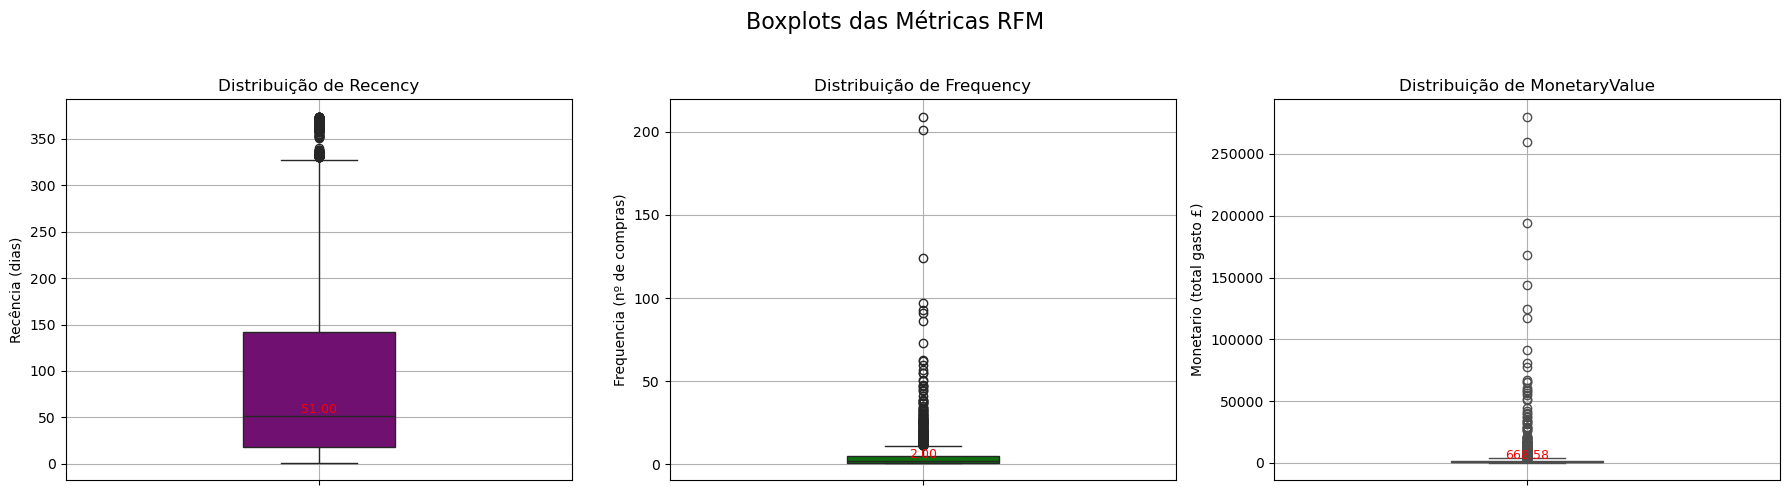

In [49]:
# 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Boxplots das Métricas RFM", fontsize=16)

# Lista das colunas e títulos
colunas = ['Recency', 'Frequency', 'MonetaryValue']
titulos = ['Recência (dias)', 'Frequencia (nº de compras)', 'Monetario (total gasto £)']
cores = ['purple', 'green', 'blue']

# Loop para criar cada boxplot
for i, col in enumerate(colunas):
    ax = axes[i]
    sns.boxplot(y=rfm_df[col], color=cores[i], ax=ax, width=0.3)
    ax.set_title(f'Distribuição de {col}')
    ax.set_ylabel(titulos[i])
    ax.set_xlabel("")  # Sem label no eixo X
    ax.grid(True)

    # Exibe valor da mediana com texto
    mediana = rfm_df[col].median()
    ax.text(0, mediana, f'{mediana:.2f}', color='red', fontsize=9, ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("\n" + "="*50 + "\n")

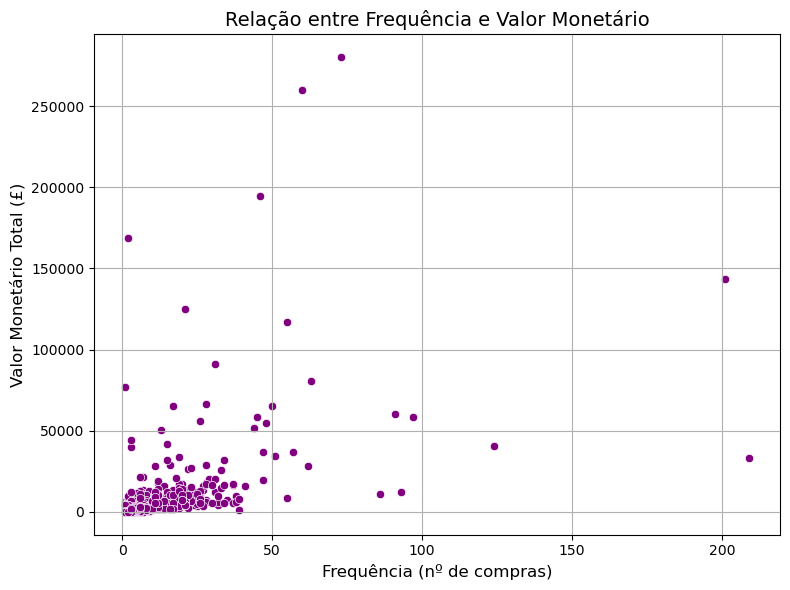

In [50]:
# Scatter plot personalizado entre Frequency e MonetaryValue
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='MonetaryValue', color='purple')

plt.title('Relação entre Frequência e Valor Monetário', fontsize=14)
plt.xlabel('Frequência (nº de compras)', fontsize=12)
plt.ylabel('Valor Monetário Total (£)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

As distribuições das métricas RFM comprovam a presença desses dois grupos de clientes distintos: uma grande população com comportamento de varejo e um pequeno grupo de alto valor, característico de atacadistas.

Dado esse contexto, o desafio é tratar o desbalanceamento causado pelos valores extremos para realizar uma segmentação eficaz, sem perder informações ou distorcer os resultados. Pensei em duas opções:

**Opção 1: Manter todos os dados e usar transformação logarítmica**
- Aplicar log1p nas colunas numéricas para reduzir o impacto dos outliers.
- Padronizar os dados (StandardScaler) após a transformação.
- Aplicar o K-Means em todo o conjunto.

**Opção 2: Segmentar em Varejo e Atacado**
- Separar os dados usando um limiar.
- Fazer clusterização apenas no grupo de varejo.
- Analisar o grupo de atacado separadamente.

Para evitar distorção na análise e gerar insights mais acionáveis para ambos, seguirei com a **Opção 2: Segmentar em Varejo e Atacado**.

- Os atacadistas têm um peso significativo no faturamento. Separar os segmentos permite desenvolver estratégias específicas para cada grupo, aumentando a relevância prática dos insights.
  - Ao isolar os atacadistas, a segmentação no grupo de varejo será mais precisa, livre da influência de valores extremos que poderiam distorcer os clusters.
  - Os atacadistas podem revelar padrões específicos.

<hr style="border: none; border-top: 1px dashed #ccc;">

#### Análise dos Pontos de Corte:

Vou avaliar diversos quantis do valor monetário total por cliente, identificando o melhor threshold para diferenciar perfis de compra de varejo e atacado.

In [51]:
# Limites pelo IQR
percentile25 = rfm_df['MonetaryValue'].quantile(0.25)
percentile75 = rfm_df['MonetaryValue'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(f"Estatísticas para detecção de outliers na coluna 'MonetaryValue':")
print()
print(f"Percentil 25%: {percentile25:.2f}")
print(f"Percentil 75%: {percentile75:.2f}")
print(f"IQR (Intervalo Interquartil): {iqr:.2f}")
print()
print(f"Limite inferior: {lower_limit:.2f}")
print(f"Limite superior: {upper_limit:.2f}")
print(f"Valores abaixo do limite inferior: {sum(rfm_df['MonetaryValue'] < lower_limit)}")
print(f"Valores acima do limite superior: {sum(rfm_df['MonetaryValue'] > upper_limit)}")
print()
print(f"Percentual de outliers: {((sum(rfm_df['MonetaryValue'] < lower_limit) + sum(rfm_df['MonetaryValue'] > upper_limit)) / len(rfm_df) * 100):.2f}%")
print("\n" + "="*50 + "\n")

Estatísticas para detecção de outliers na coluna 'MonetaryValue':

Percentil 25%: 306.45
Percentil 75%: 1660.90
IQR (Intervalo Interquartil): 1354.45

Limite inferior: -1725.23
Limite superior: 3692.58
Valores abaixo do limite inferior: 0
Valores acima do limite superior: 424

Percentual de outliers: 9.79%




In [52]:
# Limites superiores por percentis extremos
limite_98 = rfm_df['MonetaryValue'].quantile(0.98)
limite_99 = rfm_df['MonetaryValue'].quantile(0.99)
limite_995 = rfm_df['MonetaryValue'].quantile(0.995)

print(f"Limite superior (quantil 98.0%):  {limite_98:.2f}")
print(f"Limite superior (quantil 99.0%):  {limite_99:.2f}")
print(f"Limite superior (quantil 99.5%):  {limite_995:.2f}")
print()

Limite superior (quantil 98.0%):  11096.44
Limite superior (quantil 99.0%):  19781.59
Limite superior (quantil 99.5%):  41042.12



**Quantil 98.0% (Valor: £ 11.096,44)**

- O corte de £11 mil ajuda a isolar um grupo maior de "superclientes", mas esse valor, embora alto, pode ser atingido por clientes de varejo altamente engajados ao longo do ano. Isso torna o critério arriscado, pois pode levar à classificação equivocada desses consumidores como atacadistas, prejudicando a análise ao possivelemnte remover do varejo justamente seus melhores clientes.

**Quantil 99.5% (Valor: £ 41.042,12)**

- O corte de £ 41 mil é extremamente seletivo, oferecendo quase absoluta certeza de que qualquer cliente acima desse valor é um atacadista. No entanto, ele é tão seletivo que pode acabar excluindo "atacadistas menores" com padrões de compra distintos do varejo, mas que não atingem esse nível de gasto. O salto de quase £ 20 mil entre o quantil 99 e o 99,5 reforça que esse limite é bastante extremo, capturando apenas os "mega-atacadistas".

**Quantil 99.0% (Valor: £ 19.781,59)**

- Este valor representa um limiar alto o suficiente para ser inatingível para a maioria dos clientes de varejo, mas inclusivo o bastante para capturar a maior parte do comportamento de atacado. Clientes acima deste valor serão classificados como 'Atacado' e analisados descritivamente, enquanto os 99% restantes ('Varejo') irão para a etapa de clustering K-Means.

In [53]:
# Filtrar o DataFrame para encontrar apenas os clientes acima do limite quantil 99.0%
clientes_acima_limite = rfm_df[rfm_df['MonetaryValue'] > limite_99]

# Calcular o valor total gerado pelos clientes "outliers"
valor_total_outliers = clientes_acima_limite['MonetaryValue'].sum()

# Calcular o valor total gerado por TODOS os clientes (para comparação)
valor_total_geral = rfm_df['MonetaryValue'].sum()

# Calcular o percentual que os outliers representam do faturamento total
percentual_do_faturamento = (valor_total_outliers / valor_total_geral) * 100

# Exibir os resultados de forma clara
print(f"Número total de clientes: {len(rfm_df)}")
print(f"Número de clientes com gastos acima do limite: {len(clientes_acima_limite)}")
print(f"Isso representa {len(clientes_acima_limite) / len(rfm_df) * 100:.2f}% do total de clientes.")
print()
print(f"Faturamento total de todos os clientes: {valor_total_geral:,.2f}")
print(f"Valor total gerado por clientes 'atacadistas': {valor_total_outliers:,.2f}")
print()
print(f"Esses {len(clientes_acima_limite)} clientes ({len(clientes_acima_limite)/len(rfm_df):.2%}) são responsáveis por {percentual_do_faturamento:.2f}% do faturamento total.")

print("\n" + "="*50 + "\n")

Número total de clientes: 4333
Número de clientes com gastos acima do limite: 44
Isso representa 1.02% do total de clientes.

Faturamento total de todos os clientes: 8,883,247.87
Valor total gerado por clientes 'atacadistas': 2,849,468.17

Esses 44 clientes (1.02%) são responsáveis por 32.08% do faturamento total.




<hr style="border: none; border-top: 1px dashed #ccc;">

#### Separando o dataset:

In [54]:
# 1. Definir o ponto de corte 
ponto_de_corte = rfm_df['MonetaryValue'].quantile(0.99)

print(f"Ponto de corte definido em: £{ponto_de_corte:,.2f}")
print("-" * 50)

# 2. Criar o DataFrame de VAREJO
# Clientes cujo valor monetário é MENOR OU IGUAL ao ponto de corte
rfm_varejo = rfm_df[rfm_df['MonetaryValue'] <= ponto_de_corte].copy()

# 3. Criar o DataFrame de ATACADO
# Clientes cujo valor monetário é MAIOR que o ponto de corte
rfm_atacado = rfm_df[rfm_df['MonetaryValue'] > ponto_de_corte].copy()

# 4. Verificação dos resultados
print(f"Número de clientes no segmento Varejo: {len(rfm_varejo)}")
print(f"Número de clientes no segmento Atacado: {len(rfm_atacado)}")
print(f"Total de clientes original: {len(rfm_df)}")

print("\n--- Amostra do DataFrame de Varejo ---")
display(rfm_varejo.head())

print("\n--- Amostra do DataFrame de Atacado (ordenado por valor) ---")
display(rfm_atacado.sort_values(by='MonetaryValue', ascending=False).head())

Ponto de corte definido em: £19,781.59
--------------------------------------------------
Número de clientes no segmento Varejo: 4289
Número de clientes no segmento Atacado: 44
Total de clientes original: 4333

--- Amostra do DataFrame de Varejo ---


,Recency,Frequency,MonetaryValue
CustomerID,,,
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
12352,36,8,2506.04



--- Amostra do DataFrame de Atacado (ordenado por valor) ---


,Recency,Frequency,MonetaryValue
CustomerID,,,
14646,2,73,280206.02
18102,1,60,259657.30
17450,8,46,194390.79
16446,1,2,168472.50
14911,1,201,143711.17


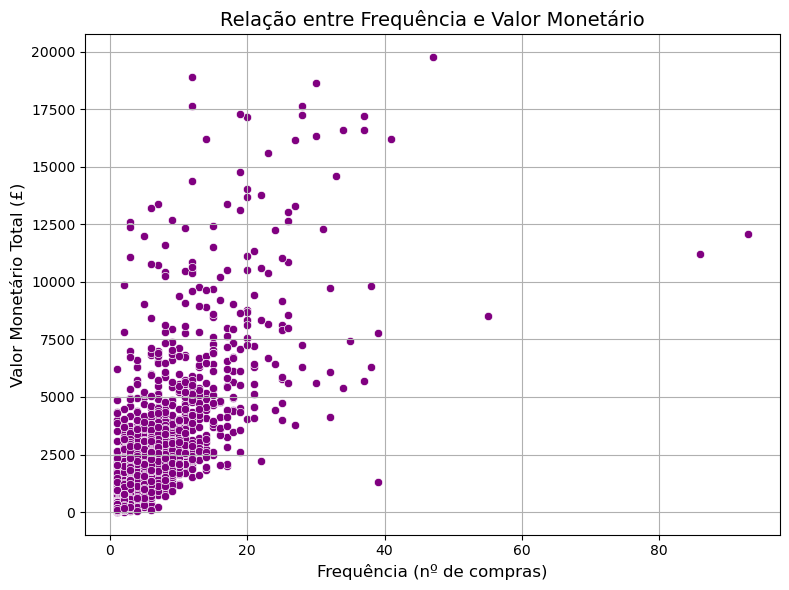

In [55]:
# Scatter plot personalizado entre Frequency e MonetaryValue
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_varejo, x='Frequency', y='MonetaryValue', color='purple')

plt.title('Relação entre Frequência e Valor Monetário', fontsize=14)
plt.xlabel('Frequência (nº de compras)', fontsize=12)
plt.ylabel('Valor Monetário Total (£)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Após a construção do DataFrame RFM, foi realizada uma análise exploratória para entender a distribuição dos clientes e definir a estratégia de segmentação mais apropriada.

* As visualizações (histogramas e boxplots) das métricas revelaram distribuições extremamente assimétricas, confirmando a existência de dois perfis de clientes distintos: uma grande base de clientes com comportamento de **varejo** e um pequeno grupo de alto valor com características de **atacado**.

* Para garantir uma segmentação precisa e acionável, optou-se por separar esses dois grupos antes de aplicar o algoritmo de clustering. Esta abordagem evita que os valores extremos do atacado distorçam a análise do varejo e permite a criação de estratégias de negócio personalizadas para cada segmento.

* Foi realizada uma análise de diferentes quantis do `MonetaryValue` para encontrar o limiar ideal. O **quantil de 99% (£ 19.781,59)** foi selecionado como o ponto de corte mais equilibrado.

* A análise confirmou a importância desta separação:
    *   O segmento **Atacado** é composto por **44 clientes (1,02% do total)**.
    *   Este pequeno grupo é responsável por **32,08% do faturamento total** da empresa.

Com base nesta análise, o DataFrame foi dividido em dois subconjuntos: `rfm_varejo` (4.289 clientes), que será utilizado para a modelagem K-Means, e `rfm_atacado` (44 clientes), que será objeto de uma análise descritiva aprofundada.

---

# **Construção**

## **Etapa 5. Construção do Modelo**

*   Transformação logarítmica nas colunas RFM.
*   Padronização com `StandardScaler`.
*   Encontrar o Número Ideal de Clusters (k).

### **5.1. Transformação Logarítmica**

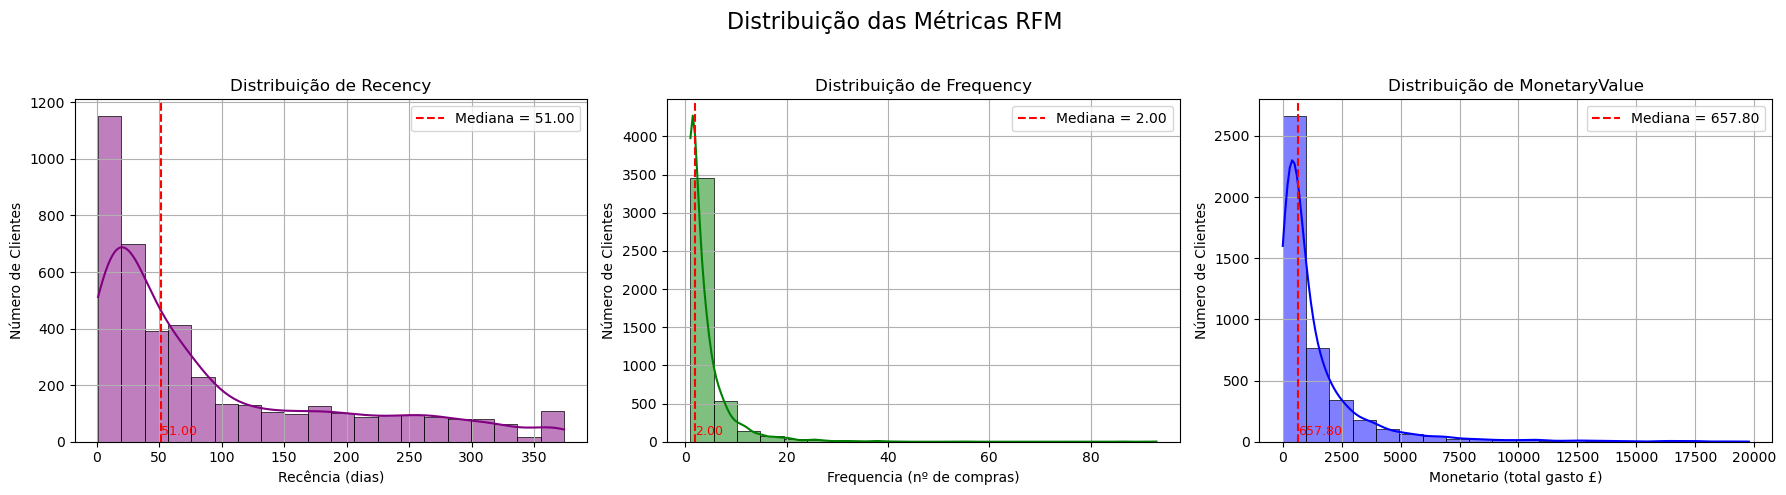

In [56]:
# 3 subgráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Distribuição das Métricas RFM", fontsize=16)

# Lista das colunas e títulos
colunas = ['Recency', 'Frequency', 'MonetaryValue']
titulos = ['Recência (dias)', 'Frequencia (nº de compras)', 'Monetario (total gasto £)']
cores = ['purple', 'green', 'blue']

# Loop para criar cada histograma
for i, col in enumerate(colunas):
    ax = axes[i]
    sns.histplot(rfm_varejo[col], bins=20, color=cores[i], kde=True, linewidth=0.5, ax=ax)
    ax.set_title(f'Distribuição de {col}')
    ax.set_xlabel(titulos[i])
    ax.set_ylabel("Número de Clientes")
    ax.grid(True)

    # Marcar mediana
    mediana = rfm_varejo[col].median()
    ax.axvline(mediana, color='red', linestyle='--', label=f'Mediana = {mediana:.2f}')
    ax.text(mediana, ax.get_ylim()[1]*0.02, f'{mediana:.2f}', color='red', fontsize=9)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()
print()

Como podemos ver demostrado acima mesmo dentro do segmento de varejo, após a separação, o gráfico ainda está fortemente assimétrico à direita. 

A transformação logarítmica irá "comprimir" a escala, puxando os valores extremos para mais perto do centro da distribuição. Isso torna a distribuição mais parecida com uma curva normal (em formato de sino), que é o cenário ideal para algoritmos baseados em distância como o K-Means.

In [57]:
# Criar uma cópia para não alterar o DataFrame original de varejo
rfm_varejo_log = rfm_varejo.copy()

# Aplicar np.log1p() a cada uma das colunas R, F e M
rfm_varejo_log['Recency'] = np.log1p(rfm_varejo_log['Recency'])
rfm_varejo_log['Frequency'] = np.log1p(rfm_varejo_log['Frequency'])
rfm_varejo_log['MonetaryValue'] = np.log1p(rfm_varejo_log['MonetaryValue'])

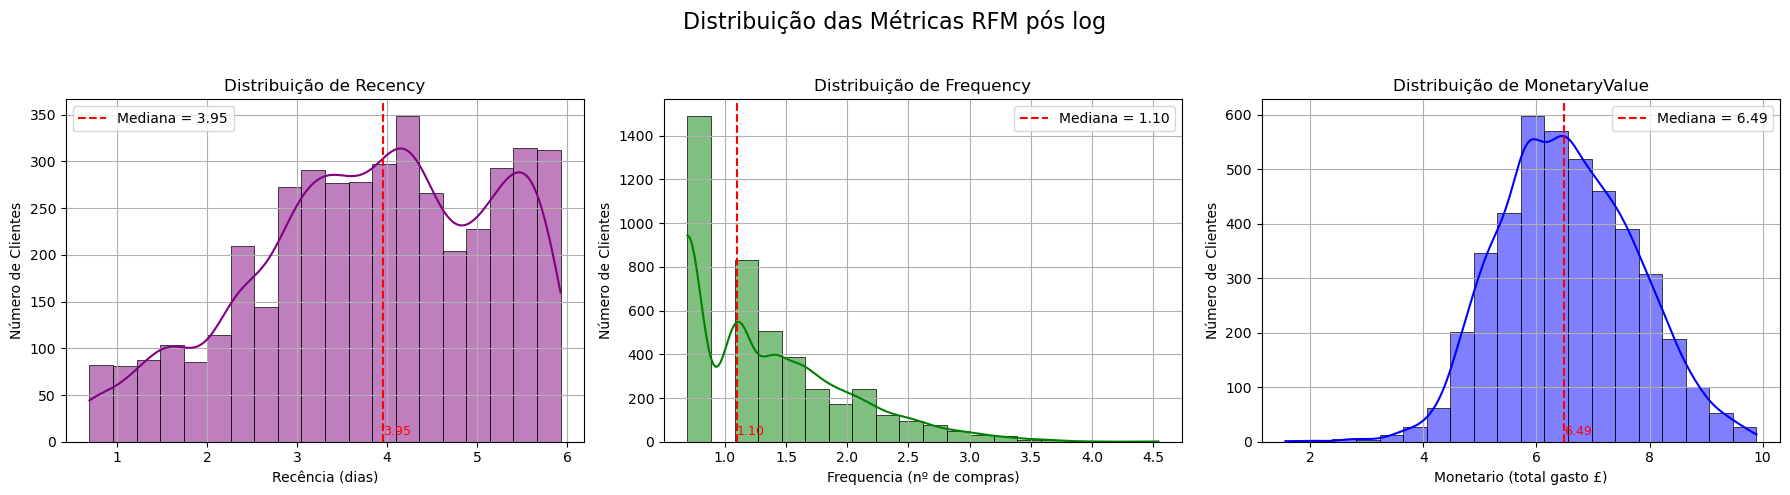

In [58]:
# 3 subgráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Distribuição das Métricas RFM pós log", fontsize=16)

# Lista das colunas e títulos
colunas = ['Recency', 'Frequency', 'MonetaryValue']
titulos = ['Recência (dias)', 'Frequencia (nº de compras)', 'Monetario (total gasto £)']
cores = ['purple', 'green', 'blue']

# Loop para criar cada histograma
for i, col in enumerate(colunas):
    ax = axes[i]
    sns.histplot(rfm_varejo_log[col], bins=20, color=cores[i], kde=True, linewidth=0.5, ax=ax)
    ax.set_title(f'Distribuição de {col}')
    ax.set_xlabel(titulos[i])
    ax.set_ylabel("Número de Clientes")
    ax.grid(True)

    # Marcar mediana
    mediana = rfm_varejo_log[col].median()
    ax.axvline(mediana, color='red', linestyle='--', label=f'Mediana = {mediana:.2f}')
    ax.text(mediana, ax.get_ylim()[1]*0.02, f'{mediana:.2f}', color='red', fontsize=9)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Para preparar os dados para o algoritmo K-Means, foi aplicada uma transformação logarítmica (`np.log1p`) nas colunas `Recency`, `Frequency` e `MonetaryValue` do segmento de varejo. O objetivo era corrigir a forte assimetria observada nas distribuições originais e normalizá-las.

*   **Resultados:**
    *   As métricas **`Recency`** e **`MonetaryValue`** responderam de forma ideal à transformação, resultando em distribuições muito próximas da normal (formato de sino), o que é excelente para algoritmos baseados em distância.
    *   A métrica **`Frequency`**, embora melhorada, manteve uma certa assimetria.

<blank>

*   **Análise da `Frequency`:** A resposta mais contida da `Frequency` à transformação é esperada e se deve à natureza desta métrica. Sendo uma contagem do número de compras, a maioria dos clientes se concentra em valores inteiros e baixos (ex: 1, 2, 3 compras). Com essa concentração em poucos valores distintos, a transformação matemática não consegue criar uma curva perfeitamente suave, como faz com o `MonetaryValue`, que possui milhares de valores únicos. No entanto, o objetivo principal foi alcançado: a escala foi drasticamente reduzida, e o impacto dos outliers foi mitigado, equilibrando a importância desta variável em relação às outras.

Com as distribuições agora muito mais equilibradas, o conjunto de dados está pronto para a próxima etapa de pré-processamento.

### **5.2. Padronização com `StandardScaler`**

As três métricas estão em escalas completamente diferentes. Recência está em "dias", Frequência em número de compras e Valor Monetário em libras. O `StandardScaler` irá transformar cada coluna para que ela tenha uma média de 0 e um desvio padrão de 1. Isso coloca todas as três métricas na mesma escala, garantindo que o K-Means dê a mesma importância para cada uma delas ao calcular as distâncias entre os clientes.

In [59]:
# Aplicando o StandardScaler nos dados já transformados pelo log
scaler = StandardScaler()
rfm_varejo_scaler = scaler.fit_transform(rfm_varejo_log)

# Exibir as primeiras duas linhas dos dados finais, prontos para o K-Means
print("\n--- Dados Finais (Log + Scaler) Prontos para o K-Means ---")
print(rfm_varejo_scaler[:2,:])


--- Dados Finais (Log + Scaler) Prontos para o K-Means ---
[[-2.07118742  1.16485692  1.53423666]
 [ 0.36335844  0.43906493  0.79859771]]


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

*   O objetivo é garantir que todas as variáveis (`Recency`, `Frequency` e `MonetaryValue`) tivessem a mesma importância para o algoritmo K-Means, que é sensível a diferenças de escala.

*   Foi aplicado o `StandardScaler` ao conjunto de dados `rfm_varejo_log`. Este processo transformou cada variável para que tivesse uma média de 0 e um desvio padrão de 1.

O resultado é um conjunto de dados totalmente preparado, onde as distâncias entre os clientes podem ser calculadas de forma justa e equilibrada. Os dados estão agora prontos para a etapa de determinação do número ideal de clusters.

### **5.3. Encontrando o Número Ideal de Clusters (K)**

Para encontrar o número ideal de segmentos de clientes, serão utilizados dois métodos: o **Método do Cotovelo (Elbow Method)** e a análise do **Coeficiente de Silhueta (Silhouette Score)**.

#### Inércia do modelo:

A seguir irei plotar a inércia do modelo (soma das distâncias quadradas dentro de cada cluster) para diferentes valores de K.

In [60]:
# Erro relacionado ao paralelismo do scikit-learn
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '1'  # Limita a 1 núcleo

In [61]:
# Definir os números de clusters
num_clusters = list(range(2, 11))

# Função que retorna a lista de inércia
def kmeans_inertia(num_clusters, x_vals):
    """
    Para cada k em num_clusters, ajusta um KMeans e
    retorna a lista de inércias correspondentes.
    """
    inertia = []
    for k in num_clusters:
        kms = KMeans(n_clusters=k, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia     

In [62]:
# Usando a função
inertia = kmeans_inertia(num_clusters, rfm_varejo_scaler)

# Exibir resultados
print("Inércia por número de clusters (k):")
for k, val in zip(num_clusters, inertia):
    print(f"k = {k}: inertia = {val:.2f}")

Inércia por número de clusters (k):
k = 2: inertia = 6299.48
k = 3: inertia = 4759.62
k = 4: inertia = 3812.64
k = 5: inertia = 3231.36
k = 6: inertia = 2767.28
k = 7: inertia = 2524.36
k = 8: inertia = 2336.06
k = 9: inertia = 2124.34
k = 10: inertia = 1952.86


<hr style="border: none; border-top: 1px dashed #ccc;">

#### Método do Cotovelo:

Agora podemos plotar esses valores em um gráfico de linha simples, com os valores de k ao longo do eixo x e a inércia no eixo y e procurar o "cotovelo" (o ponto onde a curva começa a achatar).

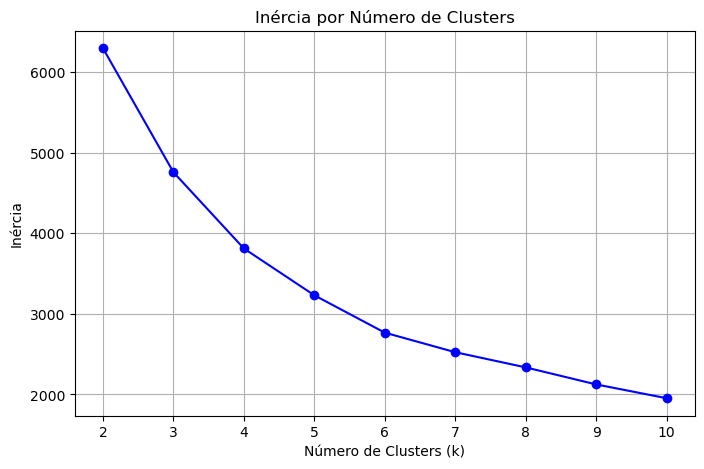

In [63]:
# Plotar Inércia vs k
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, inertia, marker='o', color='blue')
plt.title("Inércia por Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia")
plt.grid(True)
plt.xticks(num_clusters)
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

#### Coeficiente de Silhueta:

Mede quão bem cada ponto se encaixa no cluster em comparação com os outros. A pontuação vai de -1 a 1, e valores mais próximos de 1 são melhores.

In [64]:
# Avaliar a coeficiente de silhueta
def kmeans_sil(num_clusters, x_vals):
    """
    Recebe como argumentos uma lista de inteiros e um array de dados.
    Ajusta um modelo KMeans para cada valor de k.
    Calcula a pontuação de silhueta para cada valor de k.
    Retorna uma lista com essas pontuações.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    
    return sil_score

# Calcular as pontuações de silhueta para k = 2 a 10
sil_score = kmeans_sil(num_clusters, rfm_varejo_scaler)

for k, score in zip(num_clusters, sil_score):
    print(f"k = {k}: silhouette score = {score:.4f}")

k = 2: silhouette score = 0.4324
k = 3: silhouette score = 0.3308
k = 4: silhouette score = 0.3353
k = 5: silhouette score = 0.3062
k = 6: silhouette score = 0.3120
k = 7: silhouette score = 0.2863
k = 8: silhouette score = 0.2731
k = 9: silhouette score = 0.2735
k = 10: silhouette score = 0.2782


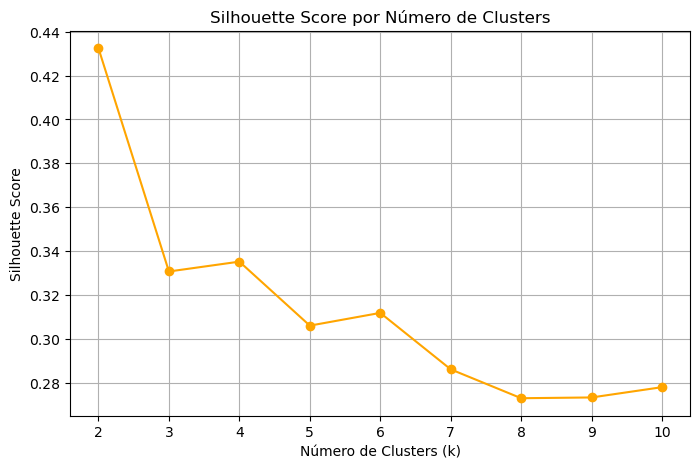

In [65]:
# Plotar Silhouette Score vs k
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, sil_score, marker='o', color='orange')
plt.title("Silhouette Score por Número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(num_clusters)
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Para definir o número ideal de clusters (K), foram utilizados o Método do Cotovelo e a Análise de Silhueta.

*   **Método do Cotovelo:** A análise da inércia indicou um "cotovelo" proeminente em **K=4**, sugerindo que este seria um número de clusters eficiente, pois representa o ponto onde adicionar mais clusters não traz uma melhoria significativa na compactação.

*   **Coeficiente de Silhueta:** A análise da pontuação de silhueta revelou que o valor matematicamente mais alto ocorreu em **K=2** (score de 0.43), indicando que a distinção mais forte nos dados é uma divisão em dois grupos. No entanto, foi observado um **pico local em K=4** (score de 0.34), seguido por uma queda consistente na pontuação para valores maiores de K.

Embora K=2 apresente a maior pontuação de silhueta, **optou-se por K=4**. Esta decisão se baseia na combinação de evidências:

- Uma segmentação com 4 clusters oferece um nível de detalhe muito mais rico e acionável para estratégias de marketing personalizadas do que uma simples divisão em dois grupos.

- O Método do Cotovelo aponta para K=4.

- A Análise de Silhueta mostra em K=4 um pico local com uma pontuação razoável, indicando uma estrutura de clusters válida.

Portanto, o modelo final será construído com **K=4 clusters**.

Para garantir a decisão de usar o quantil de 99% como ponto de corte entre Varejo e Atacado, realizei experimentos alternativos com cortes em 95% e 98%. Os resultados mostraram que o corte de **99% produziu consistentemente as pontuações de silhueta mais altas** para os valores de K mais relevantes. Isso valida que a escolha inicial de 99% foi a que melhor isolou o segmento de varejo, permitindo a formação de clusters mais coesos e distintos.

### **5.4. Aplicação do K-Means**

Vou ajustar um modelo de **4 clusters** ao conjunto de dados e checar os rótulos.

In [66]:
# Modelo 4-cluster
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans4.fit(rfm_varejo_scaler)

KMeans(n_clusters=4, random_state=42)

In [67]:
# Rótulos únicos
print('Rótulos únicos:', np.unique(kmeans4.labels_))

Rótulos únicos: [0 1 2 3]


In [68]:
# Adiciona a coluna com os rótulos numéricos do K-Means
rfm_varejo['Cluster'] = kmeans4.labels_

# Verificando
rfm_varejo.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2,7,4310.00,2
12348,75,4,1797.24,3
12349,19,1,1757.55,0
12350,310,1,334.40,1
12352,36,8,2506.04,2


Agrupar os dados por cluster e calcular a média dos valores de R, F e M para cada um. Isso nos dirá o *perfil* de cada grupo.

In [69]:
# Agrupar por cluster e calcular a média
cluster_analysis = rfm_varejo.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)

cluster_analysis

,Recency,Frequency,MonetaryValue
Cluster,,,
0,19.09,2.04,512.18
1,187.88,1.27,308.21
2,14.70,10.69,4154.19
3,80.84,3.63,1479.19


| Cluster | Recency (R) | Frequency (F) | MonetaryValue (M) | Análise Rápida                                                                 |
|---------|-------------|---------------|-------------------|--------------------------------------------------------------------------------|
| **0**   | **Baixa**   | Baixa         | Baixa             | Clientes novos ou que fizeram poucas compras, mas recentemente.               |
| **1**   | **Alta**    | **Baixa**     | **Baixa**         | Clientes que compraram uma ou duas vezes há muito tempo e gastaram pouco.     |
| **2**   | **Baixa**   | **Alta**      | **Alta**          | Os melhores clientes. Compram muito, com frequência, e compraram recentemente.|
| **3**   | Média-Alta  | Média         | Média             | Clientes consistentes e de bom valor, mas que precisam de um novo estímulo para se manterem engajados.           |


In [70]:
# Criar o dicionário de mapeamento baseado na análise
cluster_map = {
    0: 'Promissores',
    1: 'Hibernando',
    2: 'Campeões',
    3: 'Clientes Ativos'
}

# Criar a nova coluna
rfm_varejo['Segmento'] = rfm_varejo['Cluster'].map(cluster_map)

# Verificação
display(rfm_varejo.head())

# Contar quantos clientes há em cada segmento
print("\n--- Contagem de Clientes por Segmento ---")
print(rfm_varejo['Segmento'].value_counts())

,Recency,Frequency,MonetaryValue,Cluster,Segmento
CustomerID,,,,,
12347,2,7,4310.00,2,Campeões
12348,75,4,1797.24,3,Clientes Ativos
12349,19,1,1757.55,0,Promissores
12350,310,1,334.40,1,Hibernando
12352,36,8,2506.04,2,Campeões



--- Contagem de Clientes por Segmento ---
Segmento
Hibernando         1478
Clientes Ativos    1165
Campeões            827
Promissores         819
Name: count, dtype: int64


In [71]:
# Limpando o dataframe
rfm_varejo = rfm_varejo.drop('Cluster', axis=1)

# Verificação
display(rfm_varejo.head())

,Recency,Frequency,MonetaryValue,Segmento
CustomerID,,,,
12347,2,7,4310.00,Campeões
12348,75,4,1797.24,Clientes Ativos
12349,19,1,1757.55,Promissores
12350,310,1,334.40,Hibernando
12352,36,8,2506.04,Campeões


<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Cada cliente recebeu um rótulo de cluster no DataFrame `rfm_varejo`, depois calculou‑se a média das métricas RFM por cluster para identificar perfis e, por fim, cada número de cluster foi convertido em um segmento de negócio intuitivo e acionável.

* **Cluster 0: "Promissores":** Compraram muito recentemente (recência de 19 dias), mas ainda têm frequência (2 compras) e valor monetário (£512) baixos.
* **Cluster 1: "Hibernando":** Recência alta (187 dias), frequência baixa (1,27 compras) e valor monetário baixo (£308). Esse grupo está em risco de churn e precisa de reengajamento.
* **Cluster 2: "Campeões":** Recência muito baixa (14 dias), frequência altíssima (10,69 compras) e valor monetário elevado (£4.154).
* **Cluster 3: "Clientes Ativos":** Frequência (3,63 compras) e valor monetário (£1.479) muito acima da média, mas recência crescente (80 dias). Precisam de estímulos para manter o engajamento.

A análise final mostrou a distribuição dos clientes entre os segmentos, revelando que o maior grupo é o de clientes 'Hibernando' (1.478 clientes), seguido por 'Clientes Leais' (1.165), 'Campeões' (827) e 'Promissores' (819).

---

# **Execução**

## **Etapa 6. Resultados e Avaliação**

*   Criar box plots  e  scatter plots para comparar as distribuições de R, F e M entre os clusters.
*   Conclusão sobre o dataset do varejo e recomendações para compartilhar com as partes interessadas.

### **6.1. Gráficos para Comparativos de Clusters**

#### Box Plots:

Será criado três box plots separados, um para cada métrica RFM. Em cada gráfico, o eixo X será o Segmento.

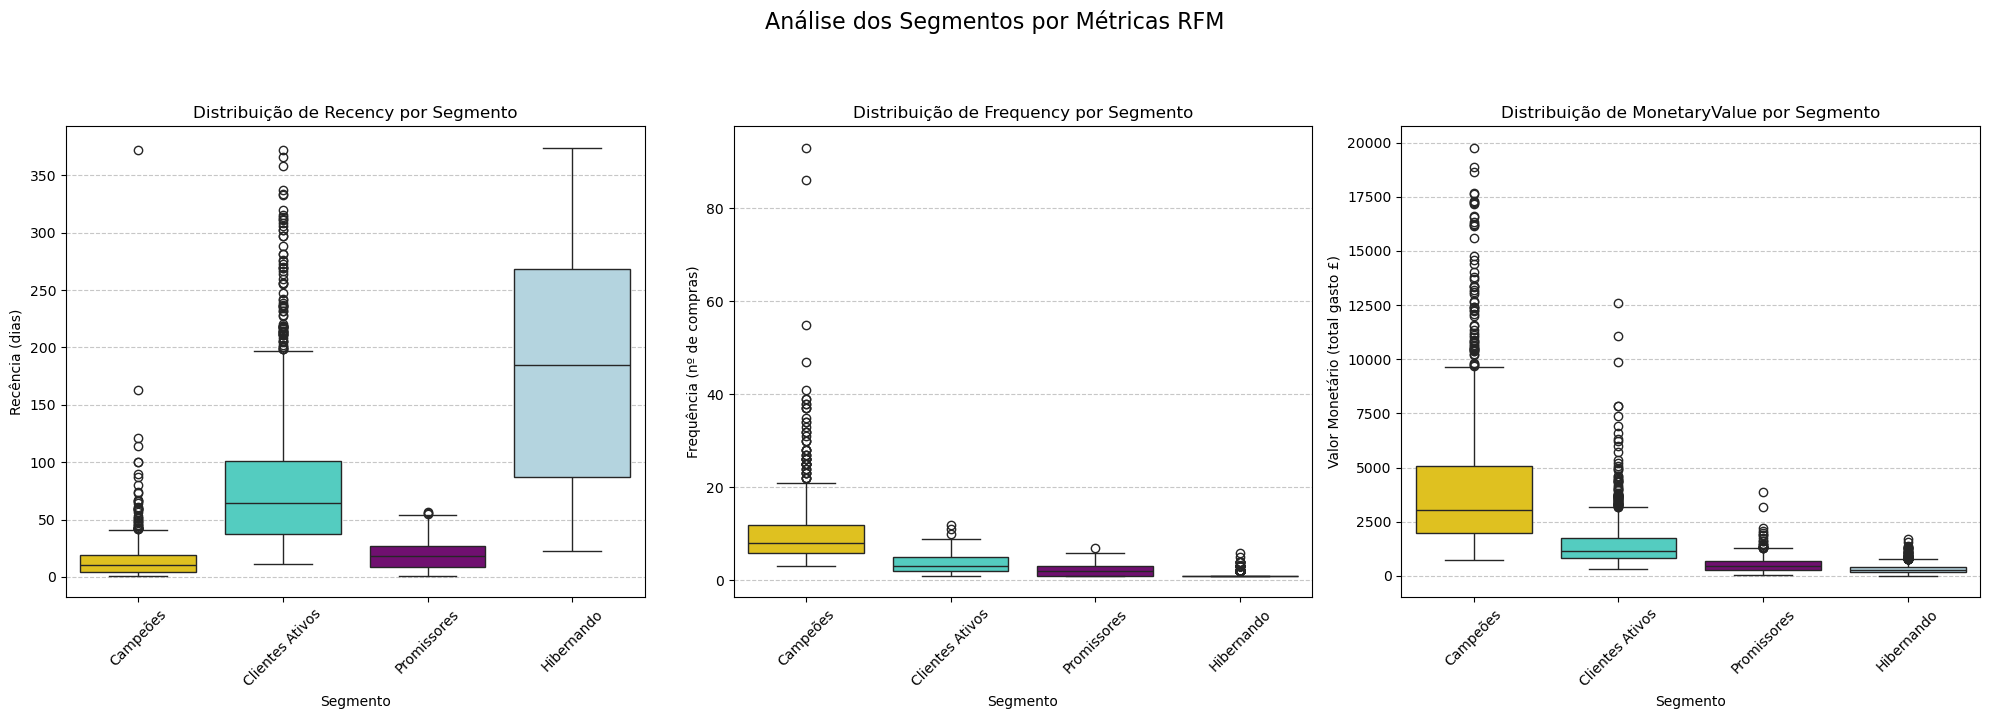

In [72]:
# Definir as colunas, títulos e paletas 
colunas_rfm = ['Recency', 'Frequency', 'MonetaryValue']
titulos_y = ['Recência (dias)', 'Frequência (nº de compras)', 'Valor Monetário (total gasto £)']
paleta_segmentos = {
    'Campeões': '#FFD700',
    'Clientes Ativos': '#40E0D0',
    'Promissores': 'purple',
    'Hibernando': '#ADD8E6'}

# 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Análise dos Segmentos por Métricas RFM", fontsize=16, y=1.02)

# Loop para criar cada um dos três boxplots
for i, metrica in enumerate(colunas_rfm):
    # Seleciona o subplot atual (ax)
    ax = axes[i]
    
    # Cria o boxplot para a métrica atual
    sns.boxplot(x='Segmento', y=metrica, data=rfm_varejo, palette=paleta_segmentos, ax=ax)
    
    # Customização do gráfico
    ax.set_title(f'Distribuição de {metrica} por Segmento', fontsize=12)
    ax.set_ylabel(titulos_y[i])
    ax.set_xlabel("Segmento")
    # Rotacionar os rótulos do eixo X se os nomes forem longos
    ax.tick_params(axis='x', rotation=45) 
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

#### Scatter Plots:

Serão gerados scatter plots 2D com o parâmetro `hue='Segmento'`, aplicando o dicionário de mapeamento de cores.

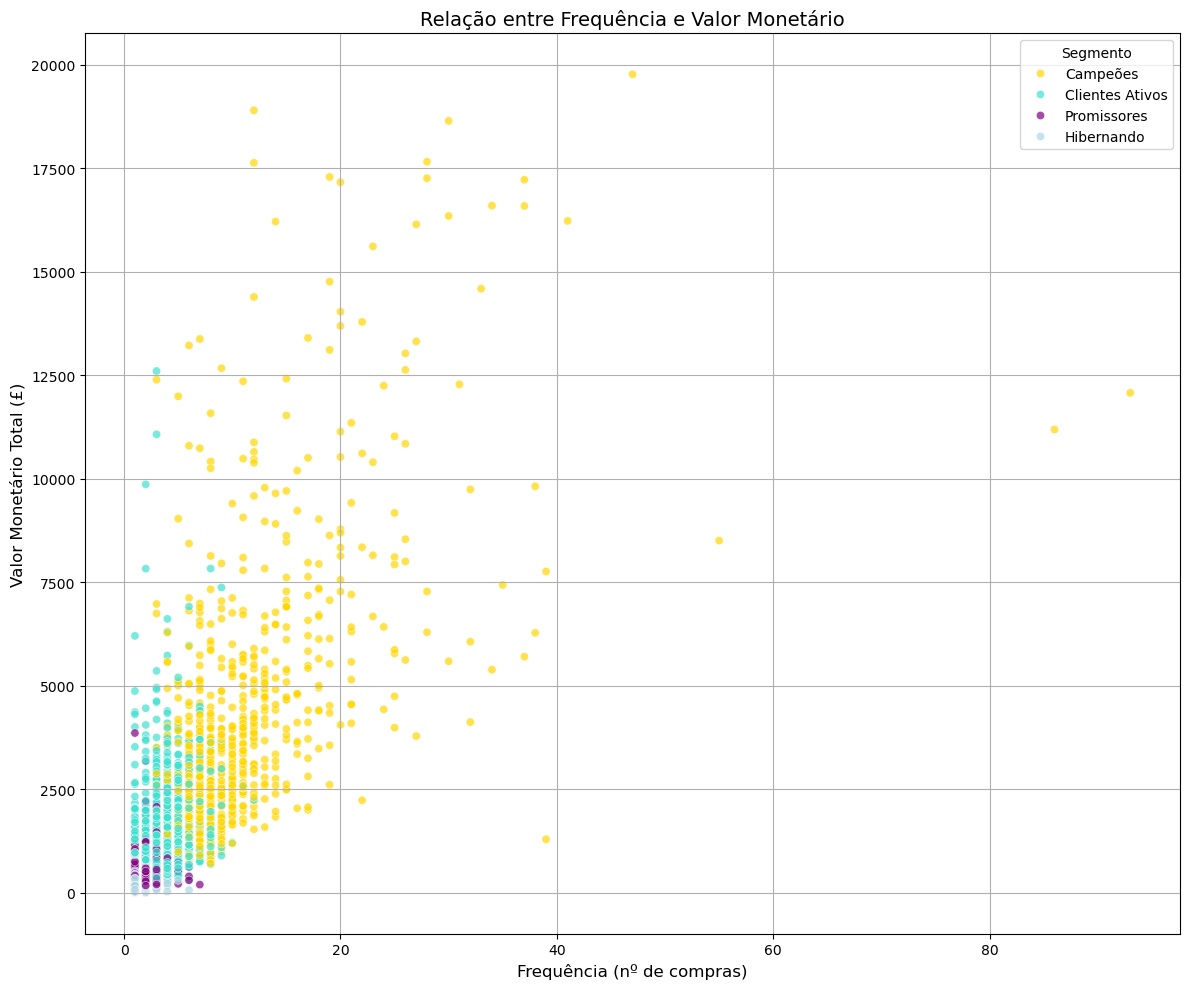

In [73]:
# Frequency vs. MonetaryValue

# Definir paletas 
paleta_segmentos = {
    'Campeões': '#FFD700',
    'Clientes Ativos': '#40E0D0',
    'Promissores': 'purple',
    'Hibernando': '#ADD8E6'}

# Scatter plot personalizado entre Frequency e MonetaryValue
plt.figure(figsize=(12, 10))
sns.scatterplot(data=rfm_varejo, x='Frequency', y='MonetaryValue', hue='Segmento', palette=paleta_segmentos, alpha=0.7)

plt.title('Relação entre Frequência e Valor Monetário', fontsize=14)
plt.xlabel('Frequência (nº de compras)', fontsize=12)
plt.ylabel('Valor Monetário Total (£)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

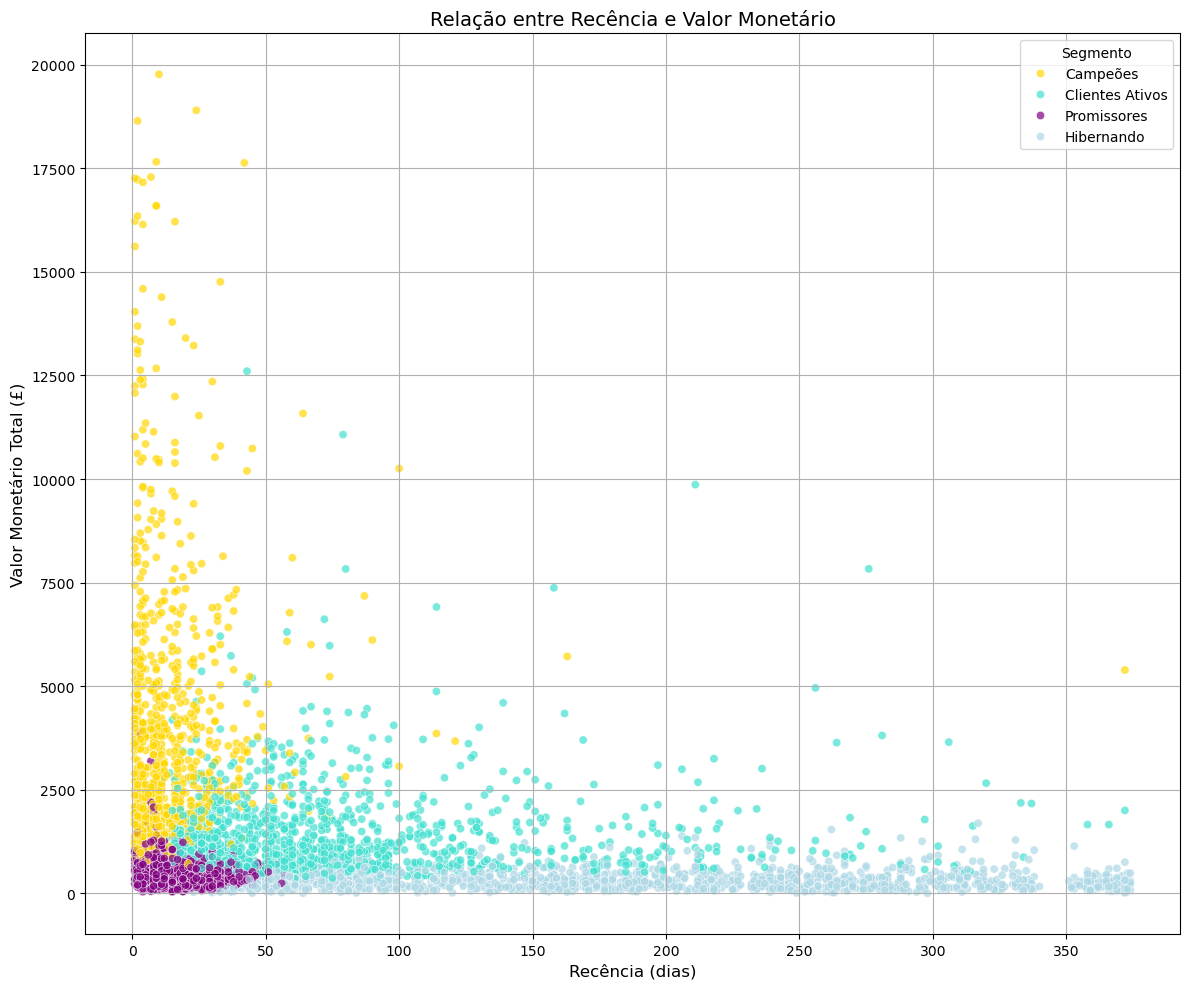

In [74]:
# Recency vs MonetaryValue

# Definir paletas 
paleta_segmentos = {
    'Campeões': '#FFD700',
    'Clientes Ativos': '#40E0D0',
    'Promissores': 'purple',
    'Hibernando': '#ADD8E6'}

# Scatter plot personalizado entre Recency e MonetaryValue
plt.figure(figsize=(12, 10))
sns.scatterplot(data=rfm_varejo, x='Recency', y='MonetaryValue', hue='Segmento', palette=paleta_segmentos, alpha=0.7)

plt.title('Relação entre Recência e Valor Monetário', fontsize=14)
plt.xlabel('Recência (dias)', fontsize=12)
plt.ylabel('Valor Monetário Total (£)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### **6.2. Resumo dos Resultados `rfm_varejo`**

A aplicação do algoritmo K-Means, com K=4, no conjunto de dados de varejo resultou em uma segmentação de clientes clara. A análise dos perfis médios de cada cluster, validada por visualizações gráficas, revelou quatro segmentos distintos:

#### **1. Campeões (827 clientes)**
*   **Quem São Eles?** Os maiores clientes de varejo. Compram com **altíssima frequência** (média de 11 visitas) e **altíssimo valor** (média de £4.154), e o fizeram **muito recentemente** (média de 15 dias).
*   **Comprovação Visual:** Nos gráficos, eles se localizam consistentemente no extremo positivo das métricas de valor (Frequência e Monetário) e no extremo positivo da métrica de engajamento (Recência).
*   **Importância para o Negócio:** São o pilar financeiro do segmento de varejo, os clientes mais engajados e valiosos.

#### **2. Clientes Ativos (1.165 clientes)**
*   **Quem São Eles?** A base de clientes consistentes. Possuem boa frequência e valor (média de 4 visitas, £1.479), mas sua **recência está aumentando** (média de 81 dias), indicando que precisam de um novo estímulo.
*   **Comprovação Visual:** Nos box plots, eles formam a "ponte" entre os Campeões e os outros grupos. O scatter plot os posiciona como um cluster intermediário claro.
*   **Importância para o Negócio:** São o núcleo do negócio. Têm alto potencial para se tornarem Campeões se forem engajados corretamente.

#### **3. Promissores (819 clientes)**
*   **Quem São Eles?** Clientes novos ou ocasionais que mostraram interesse recente. Sua principal característica é a **baixa recência** (média de 19 dias), mas ainda possuem baixa frequência e valor (média de 2 visitas, £512).
*   **Comprovação Visual:** O scatter plot de Recência vs. Monetário os isola claramente na extremidade esquerda (recente), separando-os dos clientes Hibernando.
*   **Importância para o Negócio:** São a principal fonte de novos "Clientes Ativos" e futuros "Campeões". Representam o crescimento futuro.

#### **4. Hibernando (1.478 clientes)**
*   **Quem São Eles?** O maior e mais preocupante grupo. São clientes inativos, com a **recência mais alta** (média de 188 dias) e os menores valores de frequência e gasto.
*   **Comprovação Visual:** Os gráficos os posicionam de forma inequívoca como o grupo de menor engajamento em todas as métricas.
*   **Importância para o Negócio:** Representam um risco significativo de "churn" (perda de cliente).

---

# **Análise**

## **Etapa 7. Análise do Segmento de Atacado**

Nesta seção, realizarei uma análise do grupo de **44 clientes de alto valor** que foram separados na fase de pré-processamento. O objetivo não é a clusterização, mas sim entender o perfil e a importância estratégica deste segmento para o negócio.

### **7.1. Perfil Descritivo RFM do Atacado**

Apresentarei o `.describe()` do `rfm_atacado` e destacarei as médias e medianas das variaveis comparados com segmento "Campeões" do varejo.

In [75]:
# Describe() para cada DataFrame
varejo = rfm_varejo[rfm_varejo['Segmento'] == 'Campeões'].describe().round(2)
atacado = rfm_atacado.describe().round(2)

# Concatenar os dois DataFrames de descrição lado a lado
# O parâmetro 'keys' cria um nível superior no cabeçalho das colunas
comparativo_describe = pd.concat([varejo, atacado], axis=1, keys=['Varejo', 'Atacado'])

# Exibir o resultado
display(comparativo_describe)

Varejo                         Atacado                        
      Recency Frequency MonetaryValue Recency Frequency MonetaryValue
count  827.00    827.00        827.00   44.00     44.00         44.00
mean    14.70     10.69       4154.19   24.61     43.30      64760.64
std     20.04      7.67       3263.13   63.91     44.48      60292.17
min      1.00      3.00        716.00    1.00      1.00      19788.65
25%      4.00      6.00       1984.62    1.75     16.75      28649.93
50%     10.00      8.00       3040.96    4.00     30.50      41287.90
75%     19.00     12.00       5070.74   11.25     52.00      65536.98
max    372.00     93.00      19766.59  326.00    209.00     280206.02

In [76]:
# Médias e Medianas para cada DataFrame
avg_varejo = rfm_varejo[rfm_varejo['Segmento'] == 'Campeões'].mean(numeric_only=True).round(2)
avg_atacado = rfm_atacado.mean(numeric_only=True).round(2)
median_varejo = rfm_varejo[rfm_varejo['Segmento'] == 'Campeões'].median(numeric_only=True).round(2)
median_atacado = rfm_atacado.median(numeric_only=True).round(2)

# Concatenar os DataFrames lado a lado
comparativo_describe = pd.concat([avg_varejo, avg_atacado, median_varejo, median_atacado], axis=1, keys=['Média de Varejo', 'Média de Atacado', 'Mediana de Varejo', 'Mediana de Atacado'])

# Exibir o resultado
display(comparativo_describe)

,Média de Varejo,Média de Atacado,Mediana de Varejo,Mediana de Atacado
Recency,14.70,24.61,10.00,4.0
Frequency,10.69,43.30,8.00,30.5
MonetaryValue,4154.19,64760.64,3040.96,41287.9


<hr style="border: none; border-top: 1px dashed #ccc;">

#### Gráfico barplot:

Vou criar um barplot com os dados preparados, definindo no eixo X o grupo a ser comparado, no eixo Y o valor da métrica e usando o parâmetro hue para separar as barras de Média e Mediana.

In [77]:
# Arrumar" o DataFrame. 
plot_data = comparativo_describe.T.reset_index()
plot_data.rename(columns={'index': 'Metrica'}, inplace=True)

# Criar colunas separadas para o tipo de estatística e o grupo
plot_data['Estatística'] = ['Média', 'Média', 'Mediana', 'Mediana']
plot_data['Grupo'] = ['Varejo (Campeões)', 'Atacado', 'Varejo (Campeões)', 'Atacado']

display(plot_data)

,Metrica,Recency,Frequency,MonetaryValue,Estatística,Grupo
0,Média de Varejo,14.70,10.69,4154.19,Média,Varejo (Campeões)
1,Média de Atacado,24.61,43.30,64760.64,Média,Atacado
2,Mediana de Varejo,10.00,8.00,3040.96,Mediana,Varejo (Campeões)
3,Mediana de Atacado,4.00,30.50,41287.90,Mediana,Atacado


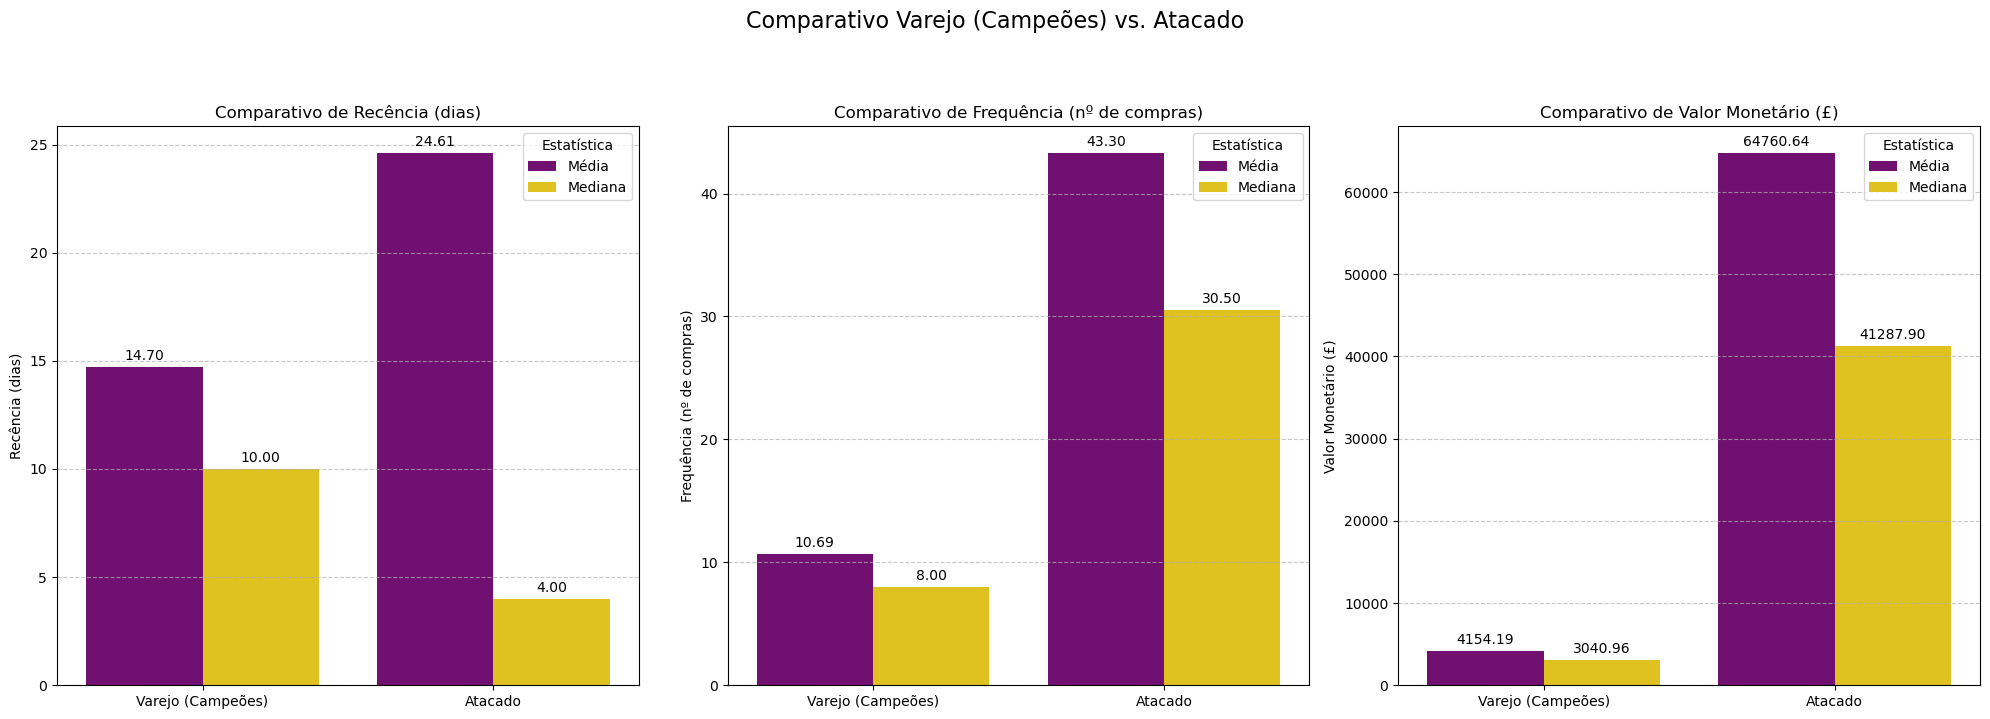

In [78]:
# Lista das colunas para o eixo Y
colunas_rfm = ['Recency', 'Frequency', 'MonetaryValue']
titulos = ['Recência (dias)', 'Frequência (nº de compras)', 'Valor Monetário (£)']
paleta_segmentos = {
    'Média': 'purple',
    'Mediana': 'gold'}

# 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Comparativo Varejo (Campeões) vs. Atacado", fontsize=16, y=1.02)


# Loop para criar cada gráfico de barras
for i, metrica in enumerate(colunas_rfm):
    ax = axes[i]
    
    # Cria o barplot
    sns.barplot(data=plot_data, x='Grupo', y=metrica, hue='Estatística', ax=ax, palette=paleta_segmentos)
    
    # Customização do gráfico
    ax.set_title(f'Comparativo de {titulos[i]}', fontsize=12)
    ax.set_ylabel(titulos[i])
    ax.set_xlabel(None)  # O 'hue' já deixa claro, não precisamos do rótulo no eixo X
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adicionar os valores exatos em cima de cada barra
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=10, padding=3)
        
    ax.legend(title='Estatística')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Uma análise descritiva foi realizada no segmento de **Atacado** (44 clientes) e comparada com o melhor grupo do Varejo, os **"Campeões"** (827 clientes), para quantificar a diferença de comportamento entre eles.

*   Foram calculadas as médias e medianas das métricas RFM para ambos os grupos, e os resultados foram visualizados em gráficos de barras para uma comparação direta.

*   **Principais Descobertas:**
    *   **Valor Monetário:** A distinção mais significativa está no valor gerado. Um cliente de atacado gasta, em média, **£64.760**, um valor **mais de 15 vezes superior** à média de um cliente "Campeão" do varejo (£4.154).
    *   **Frequência:** O comportamento de compra é muito mais intenso no atacado. Eles realizam, em média, **43 compras**, em comparação com as 11 compras dos "Campeões".
    *   **Recência:** Apesar de uma média de recência ligeiramente maior, a mediana de apenas **4 dias** para o grupo de atacado indica que metade desses clientes é extremamente ativa e realizou compras muito recentemente.

A análise comprova que os segmentos de Atacado e Varejo (mesmo em seu nível mais alto) são fundamentalmente distintos em escala e comportamento. A magnitude do valor e da frequência do segmento de Atacado justifica a decisão de separá-los para análise e a necessidade de estratégias de negócio dedicadas.

### **7.2. Padrões de Compra**

Os pontos que serão analisados:

- Produtos mais comprados
- Sazonalidade
- Tamanho Médio do Pedido
- Diversidade de Produtos

In [79]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


<hr style="border: none; border-top: 1px dashed #ccc;">

#### **Produtos mais comprados:**

Este código executará uma análise para identificar os produtos mais vendidos ao segmento de clientes de atacado. A ação começará com a obtenção da lista de IDs desses clientes. Em seguida, filtrará o DataFrame de transações para isolar apenas as compras feitas por este grupo. Por fim, o código fará a contagem dos produtos nessas transações e exibirá um ranking com os 10 itens mais populares para o público atacadista.

In [80]:
# Obter a lista de CustomerIDs do segmento de atacado
lista_ids_atacado = rfm_atacado.index

# Filtrar o DataFrame de transações original (df)
t_atacado = df[df['CustomerID'].isin(lista_ids_atacado)]

# Produtos mais vendidos
contagem_produtos = t_atacado['Description'].value_counts().head(10)

# Exibir
print("--- Top 10 Produtos Mais Vendidos para Clientes de Atacado ---")
print(contagem_produtos)

--- Top 10 Produtos Mais Vendidos para Clientes de Atacado ---
Description
JUMBO BAG RED RETROSPOT               213
WHITE HANGING HEART T-LIGHT HOLDER    194
REGENCY CAKESTAND 3 TIER              186
LUNCH BAG RED RETROSPOT               152
CHILLI LIGHTS                         145
LUNCH BAG BLACK SKULL.                121
JUMBO BAG PINK POLKADOT               120
SET OF 4 PANTRY JELLY MOULDS          113
PACK OF 72 RETROSPOT CAKE CASES       112
GUMBALL COAT RACK                     111
Name: count, dtype: int64


<hr style="border: none; border-top: 1px dashed #ccc;">

#### **Sazonalidade:**

Realizarei uma análise de sazonalidade das vendas. A ação irá extrair e formatar o mês de cada transação. Em seguida, filtrará os dados para isolar as operações dos clientes atacadistas. Por fim, agrupará as informações por mês para agregar o valor total vendido, a quantidade de transações e o valor médio por transação, exibindo uma tabela ordenada que revelará os períodos de maior faturamento para o segmento de atacado.

In [81]:
# Criar uma nova coluna `mês
df['month'] = df['InvoiceDate'].dt.month_name().str.slice(stop=3)

# Criar designações categóricas
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Codificar a coluna `mês` como categórica
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

In [82]:
# Obter a lista de CustomerIDs do segmento de atacado
lista_ids_atacado = rfm_atacado.index

# Filtrar o DataFrame de transações original (df)
t_atacado = df[df['CustomerID'].isin(lista_ids_atacado)]

# Agrupar por mês e agregar métricas
sazonalidade_atacado = t_atacado.groupby('month').agg(
    ValorTotal=('TotalPrice', 'sum'),
    TotalTransacoes=('InvoiceNo', 'nunique')
).reset_index()

# Calcular o valor médio por transação
sazonalidade_atacado['ValorMedioPorTransacao'] = (sazonalidade_atacado['ValorTotal'] / sazonalidade_atacado['TotalTransacoes']).round(2)

# Ordenar por número de valor total
sazonalidade_atacado.sort_values(by='ValorTotal', ascending=False, inplace=True)

print("--- Dados de Sazonalidade para o Segmento de Atacado ---")
display(sazonalidade_atacado)

--- Dados de Sazonalidade para o Segmento de Atacado ---


,month,ValorTotal,TotalTransacoes,ValorMedioPorTransacao
11,Dec,437510.02,243,1800.45
9,Oct,313945.54,182,1724.98
10,Nov,303756.99,237,1281.68
8,Sep,298515.28,181,1649.26
5,Jun,248449.85,149,1667.45
0,Jan,242557.90,104,2332.29
7,Aug,213600.81,139,1536.70
4,May,190296.44,174,1093.66
6,Jul,181818.14,138,1317.52
2,Mar,168263.44,133,1265.14


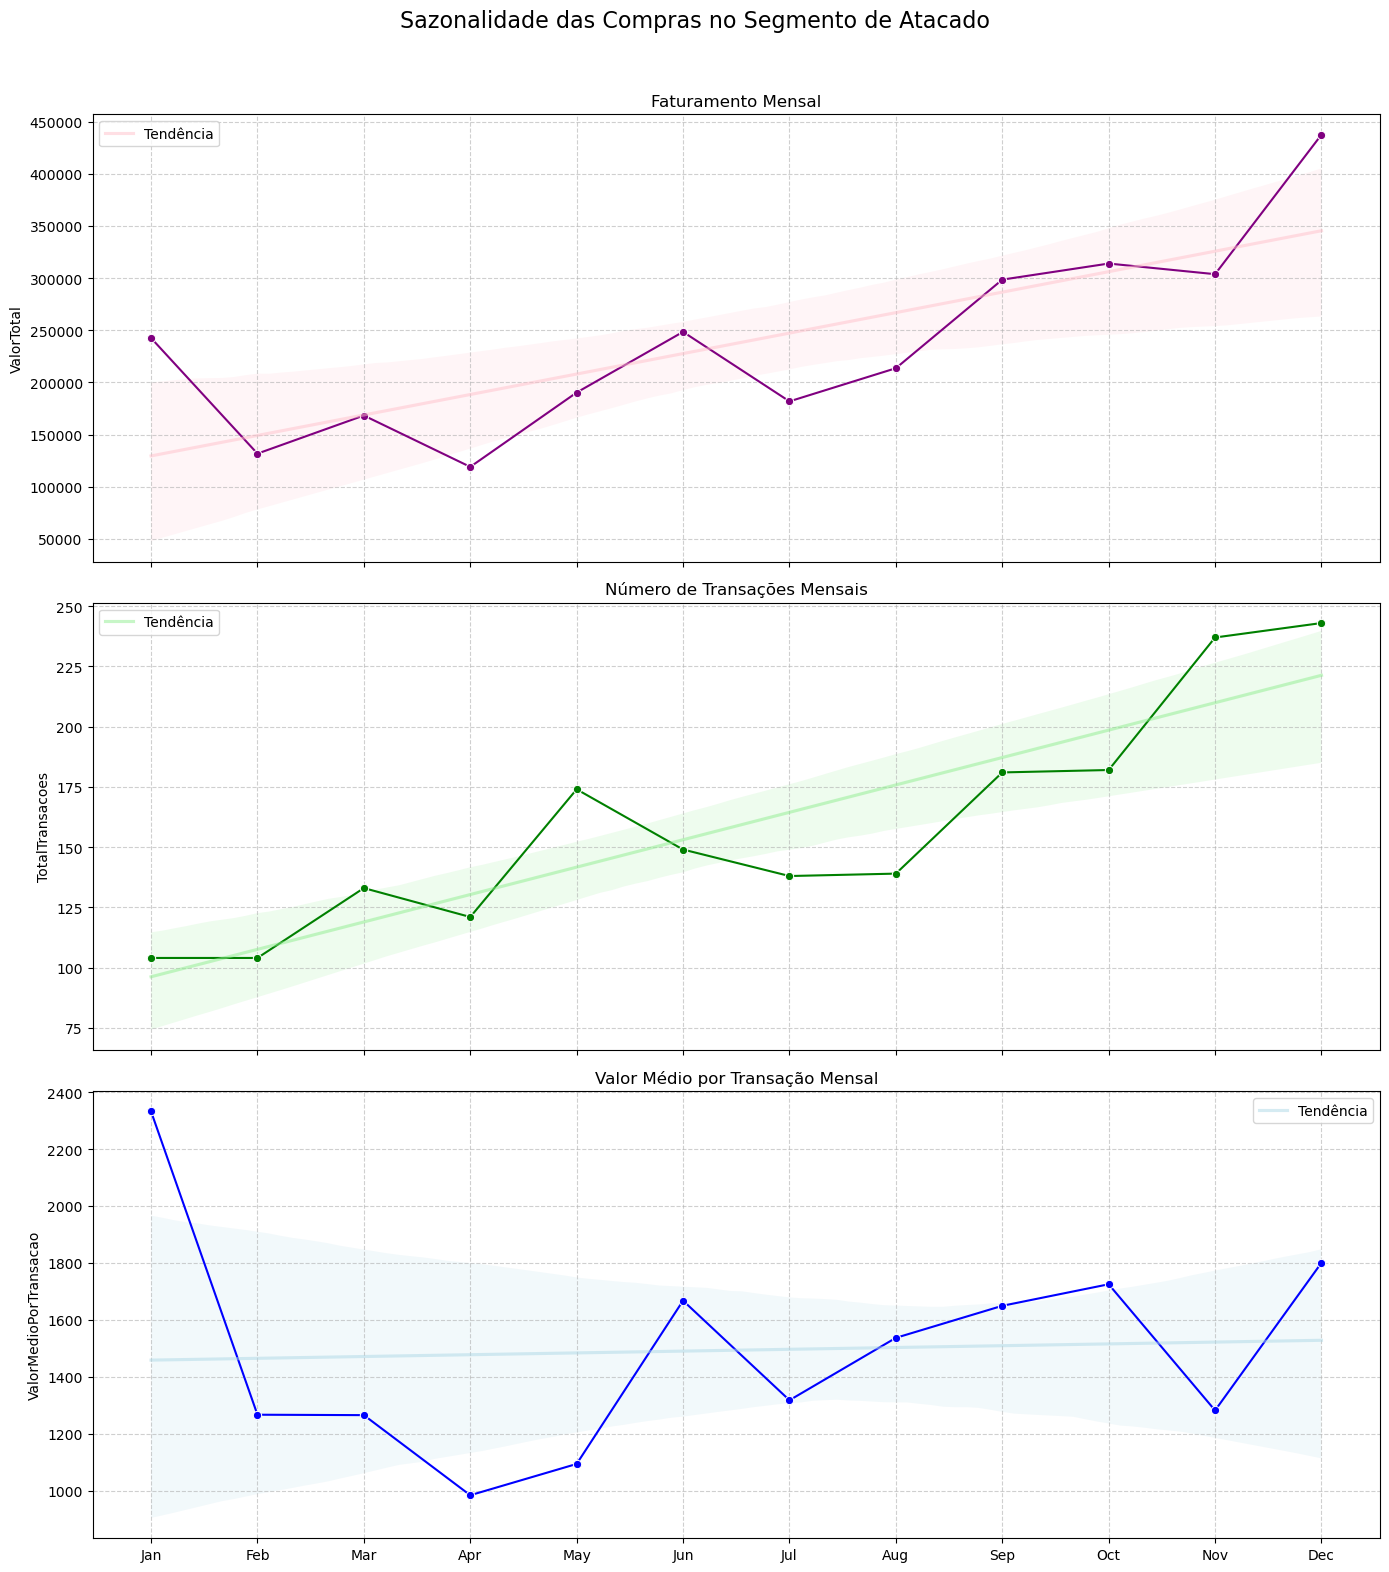

In [83]:
# 3 subplots lado a lado
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
fig.suptitle("Sazonalidade das Compras no Segmento de Atacado", fontsize=16)

# ------

# Gráfico 1: Sazonalidade do Faturamento Total
sns.lineplot(data=sazonalidade_atacado, x='month', y='ValorTotal', ax=axes[0], marker='o', color='purple')
axes[0].set_title('Faturamento Mensal')
axes[0].set_ylabel('Valor Total Gasto (£)')
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.regplot(data=sazonalidade_atacado, x=sazonalidade_atacado.index, y='ValorTotal', ax=axes[0], scatter=False, color='pink', line_kws={'alpha': 0.5}, label='Tendência')
axes[0].legend()

# ------

# Gráfico 2: Sazonalidade do Número de Transações
sns.lineplot(data=sazonalidade_atacado, x='month', y='TotalTransacoes', ax=axes[1], marker='o', color='green')
axes[1].set_title('Número de Transações Mensais')
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Nº de Transações Únicas')
axes[1].grid(True, linestyle='--', alpha=0.6)

sns.regplot(data=sazonalidade_atacado, x=sazonalidade_atacado.index, y='TotalTransacoes', ax=axes[1], scatter=False, color='lightgreen', line_kws={'alpha': 0.5}, label='Tendência')
axes[1].legend()

# ------

# Gráfico 3: Valor Médio por Transação
sns.lineplot(data=sazonalidade_atacado, x='month', y='ValorMedioPorTransacao', ax=axes[2], marker='o', color='blue')
axes[2].set_title('Valor Médio por Transação Mensal')
axes[2].set_xlabel('Mês')
axes[2].set_ylabel('Valor Médio (£)')
axes[2].grid(True, linestyle='--', alpha=0.6)

sns.regplot(data=sazonalidade_atacado, x=sazonalidade_atacado.index, y='ValorMedioPorTransacao', ax=axes[2], scatter=False, color='lightblue', line_kws={'alpha': 0.5}, label='Tendência')
axes[2].legend()

# ------

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

#### **Tamanho Médio do Pedido:**

Este código irá primeiro agrupar os dados por transação individual e calcular o valor total de cada uma. Em seguida, calculará a média, a mediana e o desvio padrão desses valores para fornecer uma visão clara sobre o ticket médio e a variabilidade das compras realizadas por este público.

In [84]:
# Calcular o valor total de cada transação
valor_por_transacao = t_atacado.groupby('InvoiceNo')['TotalPrice'].sum()

# Calcular as estatísticas
valor_medio_transacao = valor_por_transacao.mean()
mediana_valor_transacao = valor_por_transacao.median()
desvio_padrao_valor_transacao = valor_por_transacao.std()

print("--- Amostra do Valor por Transação ---")
print(valor_por_transacao.head())
print("\n" + "="*50 + "\n")
print("--- Análise do Valor das Transações ---")
print()
print(f"Valor Médio por Transação: £{valor_medio_transacao:,.2f}")
print(f"Mediana do Valor por Transação: £{mediana_valor_transacao:,.2f}")
print(f"Desvio Padrão do Valor por Transação: £{desvio_padrao_valor_transacao:,.2f}")
print()

--- Amostra do Valor por Transação ---
InvoiceNo
536381     449.98
536386     508.20
536387    3193.92
536390    1825.74
536394    1024.68
Name: TotalPrice, dtype: float64


--- Análise do Valor das Transações ---

Valor Médio por Transação: £1,495.78
Mediana do Valor por Transação: £534.00
Desvio Padrão do Valor por Transação: £4,998.36



Esse gráfico ajudará a identificar se há predominância de transações de baixo valor e a frequência de transações com valores elevados, o que pode indicar concentração de receita em poucos pedidos.

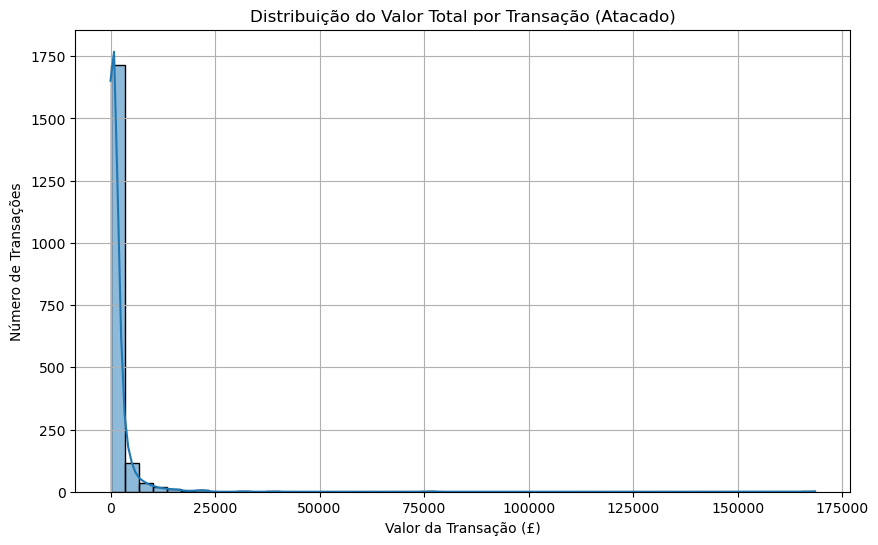

In [85]:
# Ver a distribuição dos valores das transações
plt.figure(figsize=(10, 6))
sns.histplot(valor_por_transacao, bins=50, kde=True)
plt.title('Distribuição do Valor Total por Transação (Atacado)')
plt.xlabel('Valor da Transação (£)')
plt.ylabel('Número de Transações')
plt.grid(True)
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

#### **Diversidade de Produtos:**

O código irá agrupar os dados por cada compra para calcular a quantidade de itens únicos, o volume total de produtos e o valor monetário. Por fim, os resultados serão ordenados para exibir as transações com a maior variedade de itens, revelando as cestas de compras mais diversificadas deste público.

In [86]:
# Calcular itens únicos e valor total por transação
diversidade_produtos = t_atacado.groupby('InvoiceNo').agg(
    ItensUnicos=('StockCode', 'nunique'),  # Quantos produtos diferentes
    QuantidadeTotal=('Quantity', 'sum'),   # Quantidade total de itens
    ValorTotal=('TotalPrice', 'sum')       # Valor monetário total (se existe essa coluna)
).reset_index()

# Ordenar por quantidade de itens únicos
diversidade_produtos.sort_values(by='ItensUnicos', ascending=False, inplace=True)

print("--- Diversidade de Produtos por Transação (Atacado) ---")
display(diversidade_produtos.head(10))

--- Diversidade de Produtos por Transação (Atacado) ---


,InvoiceNo,ItensUnicos,QuantidadeTotal,ValorTotal
1685,576339,541,2175,8425.54
1804,579196,529,2106,8107.72
1863,580727,525,2193,8935.98
1766,578270,439,1801,6936.52
1587,573576,434,1265,4941.71
1337,567656,419,1211,4936.65
1657,575607,375,1014,4358.00
1508,571441,363,995,4050.61
1546,572552,352,843,3472.42
1477,570488,347,779,3380.86


In [87]:
# Calcular correlação entre Quantidade e Itens Únicos
correlacao = diversidade_produtos['QuantidadeTotal'].corr(diversidade_produtos['ItensUnicos'])

print(f"\nCorrelação entre Quantidade e Itens Únicos: {correlacao:.3f}")

# Interpretação
if correlacao > 0.7:
    print("→ Correlação Forte")
elif correlacao > 0.3:
    print("→ Correlação moderada")
else:
    print("→ Correlação fraca")

print("\n" + "="*50 + "\n")


Correlação entre Quantidade e Itens Únicos: 0.102
→ Correlação fraca




Irei gerar um gráfico de dispersão para visualizar a relação entre a variedade de produtos e o volume total de itens nas transações de atacado. O eixo X representará o número de produtos únicos em uma compra, enquanto o eixo Y mostrará a quantidade total de itens.

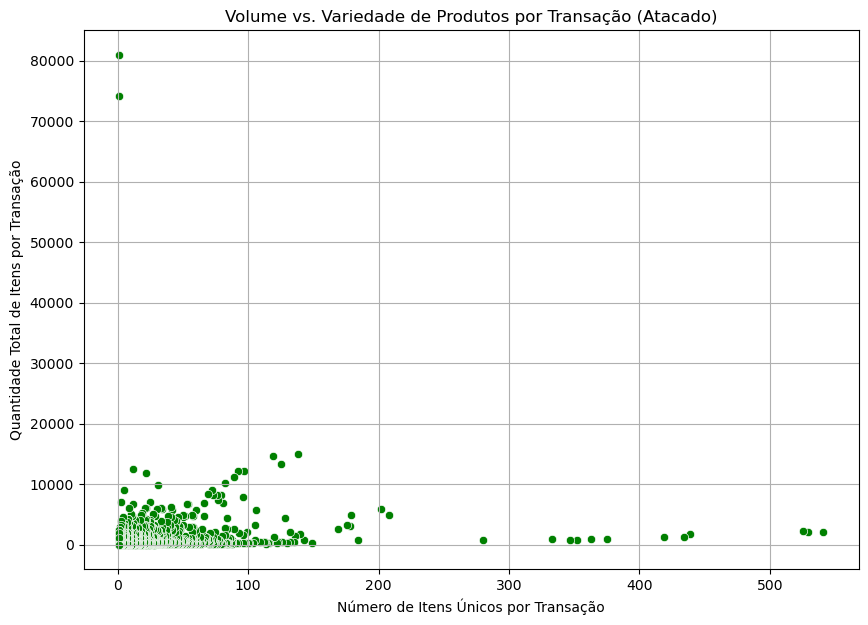

In [88]:
# Scatter plot para visualizar a relação entre volume e variedade
plt.figure(figsize=(10, 7))
sns.scatterplot(data=diversidade_produtos, x='ItensUnicos', y='QuantidadeTotal', color='green')

plt.title('Volume vs. Variedade de Produtos por Transação (Atacado)')
plt.xlabel('Número de Itens Únicos por Transação')
plt.ylabel('Quantidade Total de Itens por Transação')
# Opcional: usar escala log para ver melhor a distribuição
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A análise aprofundada dos padrões de compra do segmento de Atacado revelou insights estratégicos sobre seu comportamento, que são distintos do público de varejo.

*   **1. Foco em Produtos Específicos:** A análise dos produtos mais vendidos mostra uma forte preferência por itens de decoração e utilidades domésticas, como "JUMBO BAG RED RETROSPOT" e "WHITE HANGING HEART T-LIGHT HOLDER", indicando um provável foco em revenda destes produtos.

*   **2. Sazonalidade Pronunciada:** Existe uma clara tendência de aumento nas vendas ao longo do ano, com um **pico significativo de faturamento e número de transações no último trimestre (Outubro a Dezembro)**. Este padrão sugere que os atacadistas se preparam para a alta demanda das festas de fim de ano. Curiosamente, o valor médio por transação não segue a mesma tendência. Ele tem seu próprio padrão, com picos em Janeiro e Junho. Isso sugere que, embora o fim do ano tenha mais transações, as transações em Janeiro, por exemplo, são individualmente maiores.

*   **3. Concentração de Receita em Grandes Pedidos:** O valor médio por transação é de £1.495, mas a mediana é de apenas £534. Esta grande diferença, confirmada por uma distribuição de valores de transação fortemente assimétrica, indica que a receita do atacado é **impulsionada por um pequeno número de pedidos de altíssimo valor**, enquanto a maioria das transações é de um porte mais modesto.

*   **4. Diversidade de Estratégias de Compra:** A análise da cesta de compras revelou uma **correlação fraca entre a variedade de produtos e o volume total de itens**. Isso sugere a existência de dois perfis de compra distintos dentro do próprio segmento de atacado:
    *   **Clientes "Especialistas":** Que compram um grande volume de poucos produtos específicos.
    *   **Clientes "Generalistas":** Que compram uma vasta gama de produtos diferentes em menor quantidade por item.

O segmento de atacado não é monolítico. Ele possui uma sazonalidade clara, é dependente de grandes pedidos pontuais e engloba clientes com diferentes estratégias de compra. A gestão deste segmento requer um entendimento dessas nuances para otimizar o estoque, a logística e as abordagens de vendas.

### **7.3. Distribuição Geográfica**

Em seguida executarei uma análise da distribuição geográfica dos clientes e transações de atacado. A ação irá calcular o número total de transações e a quantidade de clientes únicos para cada país. Consolidarei esses dados em uma tabela e um gráfico oferecendo uma visão comparativa da atividade comercial por região.

In [89]:
# Calcular o número de transações por país
t_por_pais = t_atacado['Country'].value_counts()

# Calcular o número de clientes únicos por país
cliente_por_pais = t_atacado.groupby('Country')['CustomerID'].nunique()

# Juntar as duas séries em um único df
comparativo_paises = pd.DataFrame({
    'Clientes Únicos': cliente_por_pais,
    'Transações': t_por_pais 
})

# Ordenar por número de clientes
comparativo_paises.sort_values(by='Transações', ascending=False, inplace=True)

# Exibir o resultado final
print("--- Distribuição de Transações vs. Clientes Únicos por País ---")
display(comparativo_paises)

--- Distribuição de Transações vs. Clientes Únicos por País ---


,Clientes Únicos,Transações
Country,,
United Kingdom,36,31925
Ireland,2,7065
Netherlands,1,2076
Australia,1,714
Germany,1,459
Singapore,1,222
Sweden,1,198
Japan,1,197


Este código irá gerar um gráfico de barras para visualizar a frequência de compra dos clientes de atacado por país. Primeiramente, calculará a média de transações por cliente para cada localidade. Em seguida, criará um gráfico onde cada país é apresentado com seu respectivo índice de frequência, permitindo uma análise clara sobre em quais mercados os clientes realizam compras com maior regularidade.

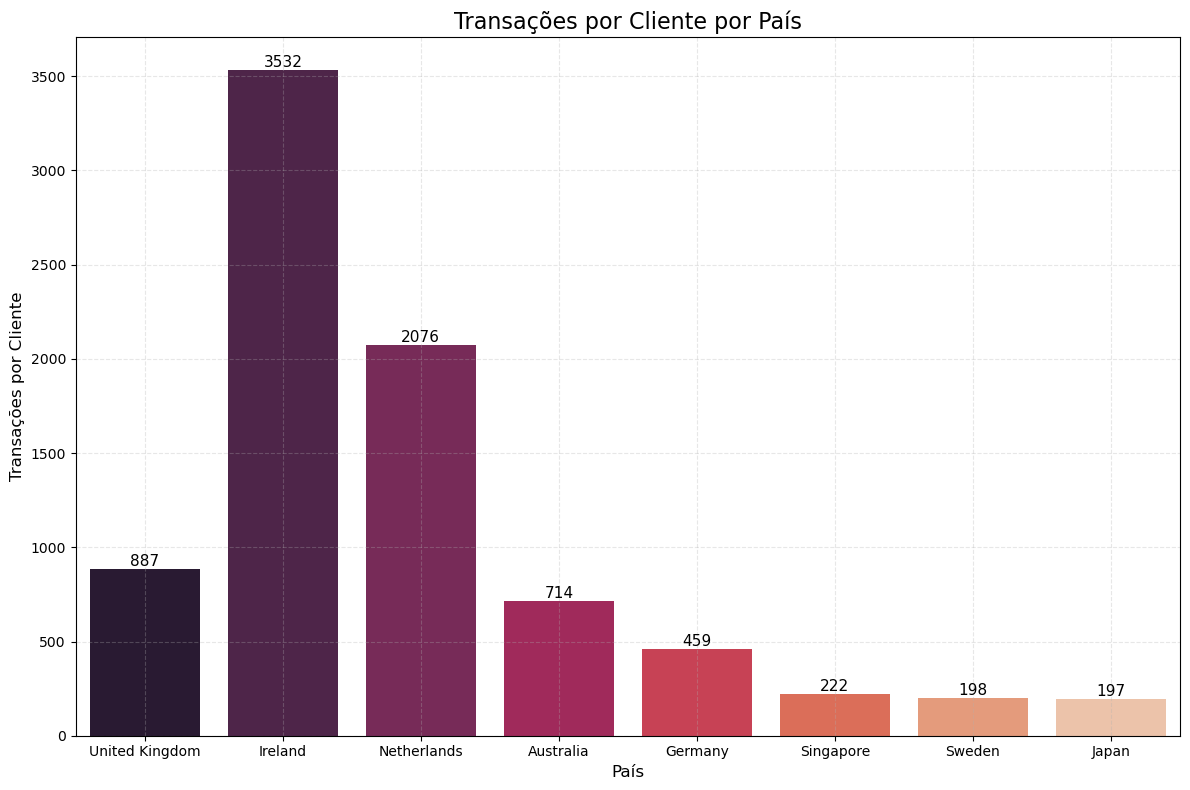

In [90]:
# Calcular transações por cliente
comparativo_paises['Transações_por_Cliente'] = comparativo_paises['Transações'] / comparativo_paises['Clientes Únicos']

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=comparativo_paises.reset_index(), x='Country', y='Transações_por_Cliente', 
            palette='rocket', ax=ax)
ax.set_title('Transações por Cliente por País', fontsize=16)
ax.set_xlabel('País', fontsize=12)
ax.set_ylabel('Transações por Cliente', fontsize=12)
ax.tick_params(axis='x')
ax.grid(True, linestyle='--', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(comparativo_paises['Transações_por_Cliente'].values):
    ax.text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

A análise da distribuição geográfica do segmento de atacado revela um modelo de negócio altamente concentrado e estratégico.

* Foram calculados o número de clientes únicos e o total de transações por país. A partir disso, foi derivada a métrica "Transações por Cliente" para entender a intensidade de compra em cada mercado.

*   **Principais Descobertas:**
    *   O **Reino Unido** concentra a maior parte dos clientes de atacado (36 de 44), com uma média elevada de 887 transações por cliente.
    *   A descoberta mais significativa é a estrutura do mercado internacional. Países como **Irlanda** e **Países Baixos** são atendidos por apenas um ou dois clientes, mas que possuem uma frequência de transações extraordinariamente alta (**3.532 e 2.076 transações por cliente**, respectivamente).

O padrão de "um cliente por país" nos mercados internacionais sugere fortemente que a empresa opera com **parceiros de distribuição exclusivos ou principais** em cada região. Esses clientes não são apenas "atacadistas", mas sim canais de venda estratégicos de importância vital para a expansão internacional da empresa. Qualquer estratégia de gestão de contas chave (Key Account Management) deve dar prioridade a esses parceiros internacionais, dado seu volume e papel central no ecossistema de vendas.

### **7.4. Explorar a Variabilidade na Recência**

Agora executarei uma análise para identificar e quantificar clientes de atacado inativos. O código irá filtrar os clientes cuja última compra ocorreu há mais de 30 dias, calculando o percentual que representam do total. Em seguida, avaliará o impacto financeiro ao somar o faturamento gerado por este grupo. Por fim, exibirá uma lista priorizada destes clientes para futuras ações de reativação.

In [91]:
rfm_atacado.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12415,24,21,124914.53
12471,2,30,19788.65
12744,52,7,21279.29
12748,1,209,33053.19


<hr style="border: none; border-top: 1px dashed #ccc;">

In [92]:
# Filtrar para encontrar os clientes de atacado com recência maior que 30 dias
r_atacado_inativos = rfm_atacado[rfm_atacado['Recency'] > 30]
lista_ids_inativos = r_atacado_inativos.index

# Calcular a porcentagem que eles representam do grupo de atacado
total_atacado = len(rfm_atacado)
total_inativos = len(r_atacado_inativos)
percentual_inativos = (total_inativos / total_atacado) * 100
inativos_atacado = t_atacado[t_atacado['CustomerID'].isin(lista_ids_inativos)]


print("--- Análise de Clientes de Atacado Inativos ---")
print()
print(f"Total de clientes no segmento: {total_atacado}")
print(f"Número de clientes considerados inativos: {total_inativos}")
print(f"Percentual de inativos: {percentual_inativos:.2f}%")
print(f"Transações desses clientes: {len(inativos_atacado)}")
print("\n" + "-"*50 + "\n")

# Exibir a lista acionável de clientes inativos
clientes_inativos_para_contato = r_atacado_inativos.sort_values(by=['Recency', 'MonetaryValue'], ascending=[False, False])

print("--- Lista de Clientes Inativos ---")
display(clientes_inativos_para_contato)
print("\n" + "-"*50 + "\n")

# Calcular o valor total gasto por esse grupo de clientes inativos
valor_em_risco = clientes_inativos_para_contato['MonetaryValue'].sum()
faturamento_total_atacado = rfm_atacado['MonetaryValue'].sum()
percentual_faturamento_em_risco = (valor_em_risco / faturamento_total_atacado) * 100


print("--- Análise do Impacto Financeiro ---")
print()
print(f"Faturamento total gerado por este grupo de clientes inativos: £{valor_em_risco:,.2f}")
print(f"Isso representa {percentual_faturamento_em_risco:.2f}% do faturamento total do segmento de Atacado.")
print("\n" + "="*50 + "\n")

--- Análise de Clientes de Atacado Inativos ---

Total de clientes no segmento: 44
Número de clientes considerados inativos: 5
Percentual de inativos: 11.36%
Transações desses clientes: 477

--------------------------------------------------

--- Lista de Clientes Inativos ---


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
15749,235,3,44534.30
15098,182,3,39916.50
12744,52,7,21279.29
16029,39,63,80850.84



--------------------------------------------------

--- Análise do Impacto Financeiro ---

Faturamento total gerado por este grupo de clientes inativos: £263,764.53
Isso representa 9.26% do faturamento total do segmento de Atacado.




<hr style="border: none; border-top: 1px dashed #ccc;">

**Ações Tomadas:**

Apesar do alto valor geral do segmento de Atacado, uma análise da variabilidade na Recência foi conduzida para identificar potenciais riscos de inatividade entre esses clientes-chave.

* Foram identificados os clientes de atacado cuja última compra ocorreu há mais de 30 dias. O número de clientes e seu impacto financeiro foram quantificados.

*   **Principais Descobertas:**
    *   **Risco Quantificado:** Foi identificado que **5 dos 44 clientes** de atacado (11.36%) estão inativos há mais de um mês.
    *   **Impacto Financeiro Crítico:** Esses 5 clientes, sozinhos, são responsáveis por **£263.764**, o que corresponde a **9.26% do faturamento total** do segmento de Atacado. Este valor representa a receita que está atualmente "em risco".
    *   **O Caso Extremo:** O caso do cliente com a maior recência (**ID 12346**) sugere uma investigação para determinar se foi uma compra única ou um padrão atípico.

A análise revelou um risco financeiro significativo associado à inatividade de um pequeno número de clientes de alto valor. A lista gerada de clientes inativos, priorizada por recência e valor, serve como uma ferramenta acionável para a equipe de gestão de contas. A recomendação é um **contato proativo imediato** com esses clientes, especialmente os de maior valor histórico, para entender os motivos da pausa nas compras e trabalhar na sua reativação, mitigando a perda potencial de uma receita substancial. 

---

# **Conclusão, Recomendações e Próximas Etapas**

## Conclusão Geral do Projeto

Este projeto de análise de segmentação de clientes demonstrou com sucesso a aplicação de técnicas de aprendizado não supervisionado (K-Means) em um conjunto de dados transacionais do mundo real. Através de um processo estruturado de limpeza de dados, engenharia de atributos e modelagem, foi possível extrair insights profundos e acionáveis, revelando a existência de duas populações de clientes fundamentalmente distintas: **Varejo** e **Atacado**.

A decisão estratégica de analisar esses dois grupos separadamente foi validada pelos resultados, que permitiram uma compreensão muito mais rica e precisa do comportamento do consumidor e geraram recomendações de negócio personalizadas para cada segmento.

**Principais Descobertas no Segmento de Varejo:**

Aplicando o clustering K-Means, a base de clientes de varejo foi segmentada em quatro grupos distintos, cada um com um perfil e uma necessidade de negócio claros:

1.  **Campeões (827 clientes):** A elite do varejo, representando o grupo mais valioso e engajado, crucial para a receita e a imagem da marca.
2.  **Clientes Ativos (1.165 clientes):** A base sólida e consistente do negócio, com alto potencial para se tornarem futuros campeões.
3.  **Promissores (819 clientes):** Clientes novos ou recentes, representando a principal oportunidade de crescimento e o futuro da base de clientes.
4.  **Hibernando (1.478 clientes):** O maior segmento, composto por clientes inativos, que evidencia um desafio significativo de retenção e a necessidade de estratégias de reativação.

**Principais Descobertas no Segmento de Atacado:**

A análise descritiva dos 44 clientes de atacado revelou um segmento de altíssimo valor e com características únicas:

1.  **Impacto Financeiro Desproporcional:** Este pequeno grupo de **1% dos clientes** é responsável por **32% do faturamento total**, destacando sua importância crítica para a saúde financeira da empresa.
2.  **Modelo de Negócio B2B:** O comportamento de compra, caracterizado por uma frequência e volume monetário ordens de magnitude maiores que os do varejo, e a estrutura de "um cliente por país" nos mercados internacionais, sugerem um modelo de negócio baseado em **parceiros de distribuição estratégicos**.
3.  **Ponto Urgente:** Foi identificado que **9,26% do faturamento do atacado está em risco** devido à inatividade de apenas cinco clientes, o que exige um monitoramento proativo e uma gestão de contas chave (Key Account Management) dedicada.

<hr style="border: none; border-top: 1px dashed #ccc;">

## Recomendações

**1. Mitigação de Risco no Segmento de Atacado:**

Com base na descoberta de que 5 clientes de atacado, responsáveis por **9,26% (£263.764)** do faturamento deste segmento, estão inativos, a recomendação é a **alocação imediata de um gerente de contas ou líder de vendas para realizar um contato pessoal** com cada um desses 5 clientes. O objetivo é entender os motivos da inatividade e oferecer soluções para reativar o relacionamento, evitando a perda de uma receita estratégica.

**2. Formalização do Programa de Parceiros para o Atacado:**

A análise revelou que o segmento de atacado opera de forma fundamentalmente diferente do varejo, com um modelo que se assemelha a distribuidores exclusivos por país. A recomendação estratégica é **desenvolver e formalizar um programa de Parceiros B2B**. Isso inclui:

-   **Criar uma política de preços por volume** para incentivar compras maiores e recorrentes.
-   **Atribuir Gerentes de Contas Chave (Key Account Managers)** para os clientes de maior valor (especialmente os parceiros internacionais).
-   **Otimizar a logística e o estoque** para atender às demandas de grande escala deste segmento.

**3. Implementando a Segmentação no Marketing de Varejo:**

Utilizar os quatro segmentos de clientes de varejo definidos ('Campeões', 'Ativos', 'Promissores', 'Hibernando') para automatizar e personalizar as campanhas de marketing em todo o ciclo de vida do cliente:

-   **Nutrição (Promissores):** Criar um fluxo de boas-vindas automatizado com incentivos para a segunda compra.
-   **Engajamento (Ativos):** Implementar campanhas de cross-sell e up-sell com base no histórico de compras.
-   **Retenção (Campeões):** Desenvolver um programa VIP com benefícios exclusivos e acesso antecipado a produtos.
-   **Reativação (Hibernando):** Lançar campanhas de "win-back" com descontos progressivos, medindo cuidadosamente o retorno sobre o investimento.

**4. Aprimoramento da Coleta e Governança de Dados para Aumentar a Eficiência Analítica:**

O processo de limpeza de dados revelou que **25% das transações foram descartadas por falta de um `CustomerID`**, representando um custo de oportunidade significativo. Para melhorar a qualidade dos dados e a precisão de futuras análises, recomenda-se:

-   Tornar o campo `CustomerID` obrigatório no sistema de vendas para todas as transações que não sejam de "checkout de convidado".
-   Criar códigos padronizados para transações não relacionadas a produtos (ex: frete, taxas), para que possam ser facilmente filtradas, economizando tempo em futuras análises.
-   Implementar uma regra de negócio que impeça o registro de transações com `UnitPrice` igual a zero sem uma justificativa clara (ex: amostra, bonificação), evitando ruído nos dados.


<hr style="border: none; border-top: 1px dashed #ccc;">

## Próximas Etapas

**1. Imediato: Implantação  de um Sistema de Pontuação de Clientes e Dashboard de Segmentos**

A ação imediata é traduzir a segmentação estática em uma ferramenta dinâmica. Isso envolve:

- Desenvolver um script que possa pegar novos clientes ou dados de clientes existentes e atribuir-lhes automaticamente o segmento correto ('Campeão', 'Ativo', etc.) com base nos dados RFM mais recentes.

<blank>

- Desenvolver um painel em uma ferramenta de BI (como Power BI ou Tableau) que mostre a distribuição dos clientes pelos segmentos ao longo do tempo. Isso permitiria à equipe de marketing monitorar a saúde da base de clientes (ex: "Estamos convertendo mais 'Promissores' em 'Ativos' este mês?"), medir o impacto de suas campanhas e identificar tendências em tempo real.



**2. Médio Prazo: Análise Comparativa dos Padrões de Cesta de Compras (Varejo vs. Atacado)**

A análise inicial revelou uma correlação fraca entre a variedade e o volume de produtos no segmento de atacado, sugerindo a existência de perfis de compra "Especialistas" e "Generalistas". O próximo passo é aprofundar essa descoberta e investigar se este padrão é exclusivo do segmento de atacado ou se também se manifesta no segmento de varejo.

- Esta análise fornecerá insights cruciais para a personalização. Se os "Especialistas" existirem em ambos os segmentos, as recomendações de produtos devem focar em variações do mesmo tipo de item. Se os "Generalistas" forem mais comuns, a estratégia de venda cruzada de categorias diferentes se torna mais promissora. Entender essa dinâmica pode otimizar significativamente os motores de recomendação e as campanhas de marketing.

**3. Longo Prazo: Desenvolvimento de Modelos Preditivos**

A segmentação RFM atual avaliou o *passado*. A próxima etapa é prever o *futuro*.

- Utilizar os segmentos RFM como *features* em um modelo de aprendizado supervisionado (ex: XGBoost) para prever a probabilidade de um cliente (especialmente 'Ativos' e 'Promissores') se tornar 'Hibernando' no próximo ciclo de negócios. Isso permite intervenções de marketing mais proativas e eficazes.